In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 1- Definition of a Lasso regression function

Three different versions are implemented
- Gradient descent Lasso
- ADMM Lasso
- ADMM Distributed Lasso

In [146]:
class LassoReg:
    def __init__(self, step_size, max_iterations, l1_penalty, tolerance):
        self.step_size = step_size
        self.max_iterations = max_iterations
        self.l1_penalty = l1_penalty
        self.tolerance = tolerance
        self.m = None
        self.n = None
        self.W = None
        self.X = None
        self.Y = None
        self.J = []  # Initialize J as an empty list
        self.iterations = None

    def fit(self, X, Y, algo, agents=None):
        self.m, self.n = X.shape
        self.W = np.zeros(self.n)
        self.X = X
        self.Y = Y

        if algo == "gd":
            self.gradient_descent()
        elif algo == "admm":
            self.admm_fit()
        elif algo == "distributed_admm":
            self.distributed_admm(agents)
        else:
            raise ValueError("Invalid algorithm")

    def gradient_descent(self):
        for i in range(1, self.max_iterations + 1):
            Y_predict = self.predict(self.X).flatten()

            soft_term = self.soft_threshold(self.W, self.l1_penalty)
            dW = (-2 * self.X.T @ (self.Y - Y_predict) + soft_term) / self.m
            
            new_W = self.W - self.step_size * dW
            
            if np.linalg.norm(new_W - self.W) < self.tolerance:
                break 

            self.J.append((np.linalg.norm(new_W - self.W),))
            self.W = new_W
            self.iterations = i

    def admm_fit(self):
        rho = self.step_size
        z = np.zeros(self.n)
        u = np.zeros(self.n)
        I = np.eye(self.n)

        abs_tol = self.tolerance
        rel_tol = abs_tol * 100

        for i in range(1, self.max_iterations + 1):
            last_z = z

            self.W = np.linalg.solve(self.X.T @ self.X + rho * I, self.X.T @ self.Y + rho * (z - u))
            z = self.soft_threshold(self.W + u, self.l1_penalty / rho)
            u = u + self.W - z

            r_norm = np.linalg.norm(self.W - z)  # primary residual
            s_norm = np.linalg.norm(-rho * (z - last_z))  # dual residual
            tol_prim = np.sqrt(self.n) * abs_tol + rel_tol * max(np.linalg.norm(self.W), np.linalg.norm(-z))
            tol_dual = np.sqrt(self.n) * abs_tol + rel_tol * np.linalg.norm(rho * u)

            self.iterations = i
            self.J.append(np.array([r_norm, s_norm, tol_prim, tol_dual]))

            last_w = self.W.copy()
            norm_diff = np.linalg.norm(self.W - last_w) / np.linalg.norm(last_w)
            

            '''if (np.linalg.norm(s_norm) / rho < tol_dual and
                np.linalg.norm(r_norm) < tol_prim and
                norm_diff < abs_tol):
                break'''
            if r_norm < tol_prim and s_norm < tol_dual :
                break 

        self.W = self.W.reshape(1, -1)

    def distributed_admm(self, agents):
        rho = self.step_size
        z = np.zeros(self.n)
        I = np.eye(self.n)

        abs_tol = self.tolerance
        rel_tol = abs_tol * 100
        converged = False

        r, c = self.X.shape
        rows_per_agent = r // agents
        total_rows_used = rows_per_agent * agents

        #print(f"Total rows used: {total_rows_used}")
        #print(f"Rows per agent: {rows_per_agent}")

        splitted_X = self.X[:total_rows_used, :].reshape((rows_per_agent, agents, c))
        splitted_Y = np.reshape(self.Y[:total_rows_used], (rows_per_agent, agents))
        self.W = np.zeros((agents, c))
        u = np.zeros((agents, c))

        for i in range(1, self.max_iterations + 1):
            last_z = z
            for j in range(agents):
                self.W[j, :] = np.linalg.solve(splitted_X[:, j, :].T @ splitted_X[:, j, :] + (rho / 2) * I, splitted_X[:, j, :].T @ splitted_Y[:, j] + (rho / 2) * (z - u[j, :]))
            
            # Fusion center aggregates information from agents
            global_W = np.mean(self.W, axis=0)
            global_u = np.mean(u, axis=0)

            # Fusion center updates z based on aggregated information
            z = self.soft_threshold(global_W + global_u, self.l1_penalty / (rho * agents))

            # Distribute updated information to agents
            for j in range(agents):
                u[j, :] = u[j, :] + (self.W[j, :] - z)
                
            global_u = np.mean(u, axis=0)    

            r_norm = np.linalg.norm(global_W - z)  # primary residual
            s_norm = np.linalg.norm(-rho * (z - last_z))  # dual residual
            tol_prim = np.sqrt(self.n) * abs_tol + rel_tol * max(np.linalg.norm(global_W), np.linalg.norm(-z))
            tol_dual = np.sqrt(self.n) * abs_tol + rel_tol * np.linalg.norm(rho * global_u)

            self.iterations = i
            self.J.append((r_norm, s_norm, tol_prim, tol_dual))

            last_w = self.W.copy()
            norm_diff = np.linalg.norm(self.W - last_w) / np.linalg.norm(last_w)
            
            '''if (np.linalg.norm(s_norm) / rho < tol_dual and
                np.linalg.norm(r_norm) < tol_prim and
                norm_diff < abs_tol):
                break'''

            if r_norm < tol_prim and s_norm < tol_dual:
                converged = True
                break

        self.W = global_W.reshape(1, -1)

    def predict(self, X):
        return X @ self.W.T.flatten()

    def loss_function(self, Y, Y_predict, W):
        return 0.5 * np.sum((Y - Y_predict) ** 2) + self.l1_penalty * np.linalg.norm(W, 1)

    def soft_threshold(self, w, th):
        return np.maximum(0, w - th) - np.maximum(0, -w - th)

    def mean_squared_error(self, Y_true, Y_predicted):
        return np.mean((Y_true - Y_predicted) ** 2)

## 1.2- Definition of plot functions

In [147]:
def prediction_plot(Y_test, Y_pred, title):
    plt.scatter(Y_test, Y_pred, color='brown', label='Predicted vs. Measured')
    plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4, label='Ideal')
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

def loss_plot(J, title):
    plt.plot(J, color='brown', label='Total Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

def loss_plot_admm(J, title):
    r_loss = [row[0] for row in J]  
    s_loss = [row[1] for row in J]  

    plt.plot(r_loss, label='Primary Residual', color='purple')
    plt.plot(s_loss, label='Dual Residual', color='green')
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

In [148]:
def loss_plot_admm_val(ax, loss_data, title):
    ax.plot(np.arange(1, len(loss_data) + 1), np.array(loss_data)[:, 0], label='Primal Residual', color = 'purple')
    ax.plot(np.arange(1, len(loss_data) + 1), np.array(loss_data)[:, 1], label='Dual Residual', color = 'green')
    ax.set_xlabel('Iterazioni')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.legend()    

def loss_plot_distributed_admm_val(ax, lasso_model, title):
    r_loss = [row[0] for row in lasso_model.J]
    s_loss = [row[1] for row in lasso_model.J]

    ax.plot(np.arange(1, len(lasso_model.J) + 1), r_loss, label='Primary Residual', color='purple')
    ax.plot(np.arange(1, len(lasso_model.J) + 1), s_loss, label='Dual Residual', color='green')

    ax.set_xlabel('Iterazioni')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.legend()

# 2- Test on first synthetically generated dataset

## 2.1- Dataset generation

A simple dataset is generated to test the functioning of the 3 versions of Lasso

In [149]:
n_features = 3

X_num = np.random.rand(300, n_features)
X_cat = np.random.randint(0, 2, (300, 1))
X_cat_one_hot = pd.get_dummies(X_cat.flatten(), prefix='cat', drop_first=True).values
X = np.concatenate((X_num, X_cat_one_hot), axis=1)

y = 2 * X[:, 0] + X[:, 1] + 0.1 * np.random.randn(300)

In [150]:
print(X.shape)

X_dataframe = pd.DataFrame(X, columns=["X1", "X2", "X3", "cat_0"])
print(X_dataframe.head())

(300, 4)
         X1        X2        X3  cat_0
0  0.480246  0.025592  0.542511    0.0
1  0.086968  0.251291  0.611646    0.0
2  0.426232  0.919915  0.430655    1.0
3  0.157470  0.286080  0.488811    1.0
4  0.649626  0.222311  0.260720    1.0


In [151]:
y_dataframe = pd.DataFrame(y, columns=["Y"])
print(y_dataframe.head())

          Y
0  1.031864
1  0.403498
2  1.772851
3  0.586380
4  1.344752


Visualize distribution of data

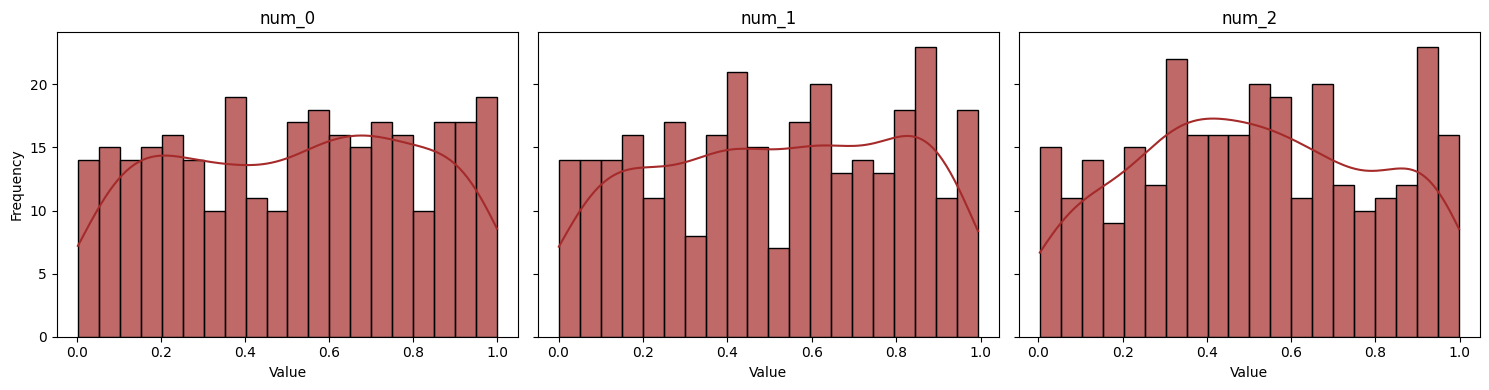

In [152]:
fig, axes = plt.subplots(1, n_features, figsize=(15, 4), sharey=True)

for i in range(n_features):
    sns.histplot(X[:, i], bins=20, kde=True, ax=axes[i], color='brown', alpha=0.7)
    axes[i].set_title(f'num_{i}')
    axes[i].set_xlabel('Value')

axes[0].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

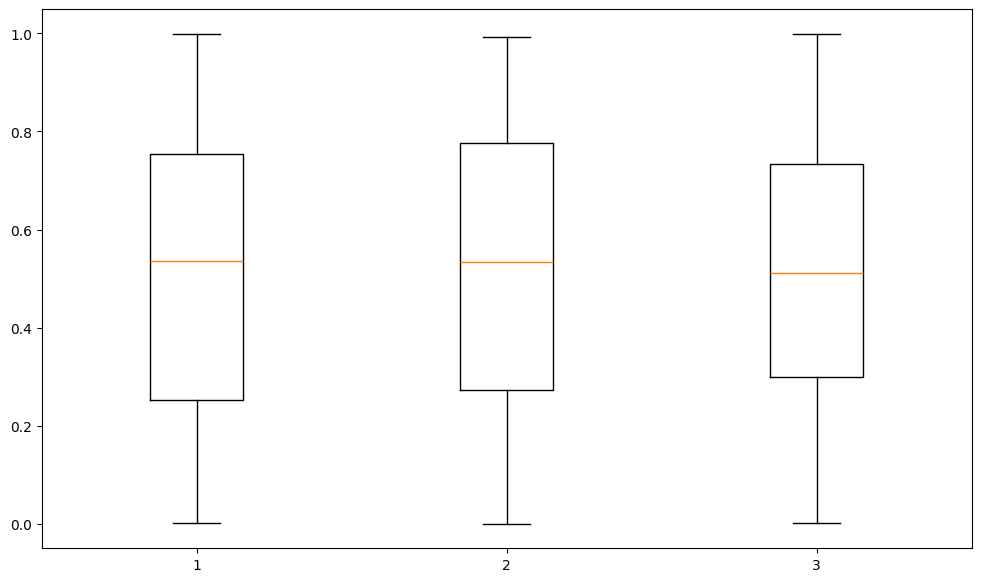

In [153]:
plt.figure(figsize=(12, 7))
plt.boxplot(X_num)
plt.show()

Visualize the distribution of target variable

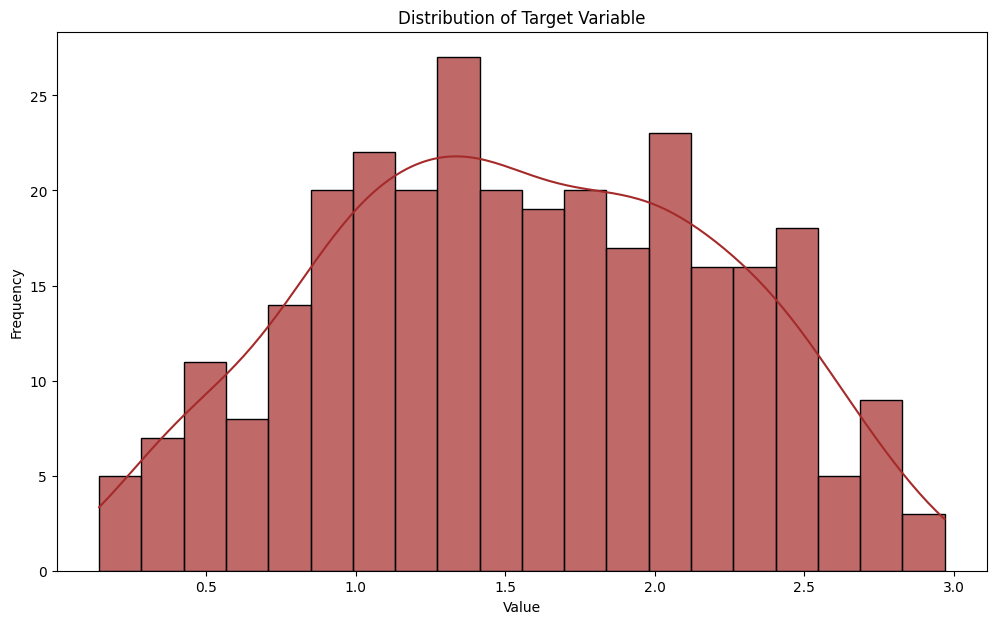

In [154]:
plt.figure(figsize=(12, 7))
sns.histplot(y, bins=20, kde=True, color='brown', alpha=0.7)
plt.title('Distribution of Target Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Division of the dataset into train set and test set

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Data normalisation

In [156]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [157]:
# parameters
step_size = 0.01
l1_penalty = 0.1
max_iterations = 100000
tolerance = 1e-3

## 2.2- Training and testing the model on the dataset evaluating the impact of the choice of parameters

### 2.2.1- Lasso Gradient Descent

Validation of step_size parameter

In [158]:
step_sizes = [0.001, 0.01, 0.1, 0.5]

for step_size in step_sizes:
    start_time = time.time()
    
    lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_gd.fit(X_train, y_train, algo="gd")
    gd_time = time.time() - start_time
    print(f"GD time with step_size {step_size}: {gd_time}")

    iterations_gd = lasso_gd.iterations
    print(f"GD iterations with step_size {step_size}: {iterations_gd}")
    
    y_pred_gd = lasso_gd.predict(X_test)

    r2 = r2_score(y_test, y_pred_gd)
    print(f"R^2 with step_size {step_size}: {r2}")

GD time with step_size 0.001: 0.02399754524230957
GD iterations with step_size 0.001: 543
R^2 with step_size 0.001: -0.2104442865292906
GD time with step_size 0.01: 0.024001121520996094
GD iterations with step_size 0.01: 543
R^2 with step_size 0.01: 0.8965165222874069
GD time with step_size 0.1: 0.006999969482421875
GD iterations with step_size 0.1: 189
R^2 with step_size 0.1: 0.9800522519718691
GD time with step_size 0.5: 0.002001523971557617
GD iterations with step_size 0.5: 57
R^2 with step_size 0.5: 0.9821332876064143


Validation of l1_penalty parameter

In [159]:
step_size = 0.5
l1_penalties = [0.01, 0.1, 1, 10]

for l1_penalty in l1_penalties:
    start_time = time.time()
    
    lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_gd.fit(X_train, y_train, algo="gd")
    gd_time = time.time() - start_time
    print(f"GD time with l1_penalty {l1_penalty}: {gd_time}")

    iterations_gd = lasso_gd.iterations
    print(f"GD iterations with l1_penalty {l1_penalty}: {iterations_gd}")
    
    y_pred_gd = lasso_gd.predict(X_test)

    r2 = r2_score(y_test, y_pred_gd)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

GD time with l1_penalty 0.01: 0.0029973983764648438
GD iterations with l1_penalty 0.01: 56
R^2 with l1_penalty 0.01: 0.9821170923369131
GD time with l1_penalty 0.1: 0.003997802734375
GD iterations with l1_penalty 0.1: 57
R^2 with l1_penalty 0.1: 0.9821332876064143
GD time with l1_penalty 1: 0.0030040740966796875
GD iterations with l1_penalty 1: 57
R^2 with l1_penalty 1: 0.9823478606151479
GD time with l1_penalty 10: 0.005006074905395508
GD iterations with l1_penalty 10: 58
R^2 with l1_penalty 10: 0.9824004921595375


### 2.2.2- Lasso ADMM

Validation of step_size parameter

ADMM time with step_size 0.001: 0.00700068473815918
ADMM iterations with step_size 0.001: 101
R^2 with step_size 0.001: 0.9825640803521963
ADMM time with step_size 0.01: 0.0009982585906982422
ADMM iterations with step_size 0.01: 11
R^2 with step_size 0.01: 0.9825644381012405
ADMM time with step_size 0.1: 0.0
ADMM iterations with step_size 0.1: 3
R^2 with step_size 0.1: 0.982569804570792
ADMM time with step_size 0.5: 0.0010001659393310547
ADMM iterations with step_size 0.5: 3
R^2 with step_size 0.5: 0.9826058751867871


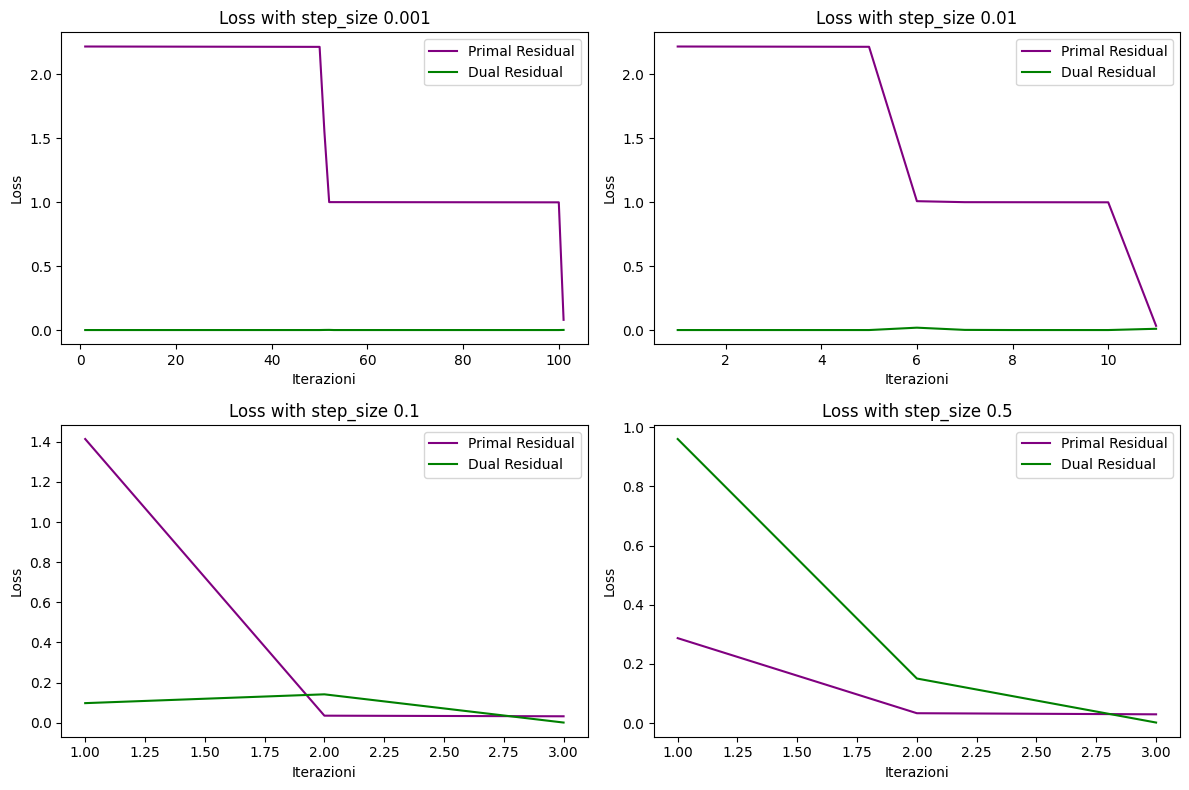

In [160]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

step_sizes = [0.001, 0.01, 0.1, 0.5]
l1_penalty = 0.1

for i, step_size in enumerate(step_sizes, 1):
    start_time = time.time()

    lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_admm.fit(X_train, y_train, algo="admm")
    admm_time = time.time() - start_time
    print(f"ADMM time with step_size {step_size}: {admm_time}")

    iterations_admm = lasso_admm.iterations
    print(f"ADMM iterations with step_size {step_size}: {iterations_admm}")

    y_pred_admm = lasso_admm.predict(X_test)

    r2 = 1 - np.mean((y_test - y_pred_admm) ** 2) / np.var(y_test)
    print(f"R^2 with step_size {step_size}: {r2}")

    while i > axs.size:
        axs = np.append(axs, plt.subplots(2, 2, figsize=(12, 8))[1], axis=0)

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_admm_val(axs[row, col], lasso_admm.J, f'Loss with step_size {step_size}')

plt.tight_layout()

plt.show()

Validation of l1_penalty parameter

ADMM time with l1_penalty 0.01: 0.00099945068359375
ADMM iterations with l1_penalty 0.01: 3
R^2 with l1_penalty 0.01: 0.9825443979009756
ADMM time with l1_penalty 0.1: 0.0
ADMM iterations with l1_penalty 0.1: 3
R^2 with l1_penalty 0.1: 0.982569804570792
ADMM time with l1_penalty 1: 0.001999378204345703
ADMM iterations with l1_penalty 1: 11
R^2 with l1_penalty 1: 0.9822611028209186
ADMM time with l1_penalty 10: 0.026002883911132812
ADMM iterations with l1_penalty 10: 195
R^2 with l1_penalty 10: 0.9512826199953163


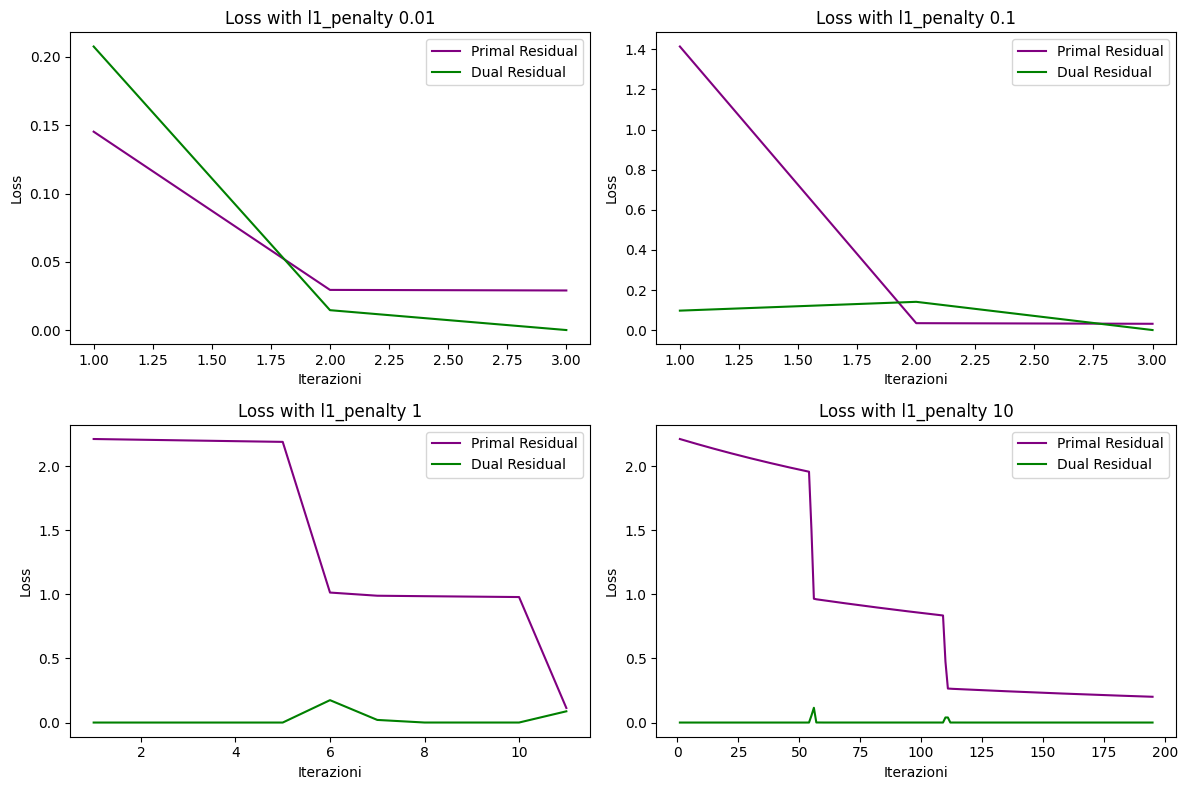

In [161]:
step_size = 0.1
l1_penalties = [0.01, 0.1, 1, 10]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, l1_penalty in enumerate(l1_penalties, 1):
    start_time = time.time()
    
    lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_admm.fit(X_train, y_train, algo="admm")
    admm_time = time.time() - start_time
    print(f"ADMM time with l1_penalty {l1_penalty}: {admm_time}")

    iterations_admm = lasso_admm.iterations
    print(f"ADMM iterations with l1_penalty {l1_penalty}: {iterations_admm}")
    
    y_pred_admm = lasso_admm.predict(X_test)

    r2 = r2_score(y_test, y_pred_admm)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

    while i > axs.size:
        axs = np.append(axs, plt.subplots(2, 2, figsize=(12, 8))[1], axis=0)

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_admm_val(axs[row, col], lasso_admm.J, f'Loss with l1_penalty {l1_penalty}')

plt.tight_layout()

plt.show()    

### 2.2.3- Lasso Distributed ADMM

Validation of step_size parameter

Distributed ADMM time with step_size 0.001: 0.009000778198242188
Distributed ADMM iterations with step_size 0.001: 34
R^2 with step_size 0.001: 0.9827064709908694
Distributed ADMM time with step_size 0.01: 0.0010004043579101562
Distributed ADMM iterations with step_size 0.01: 5
R^2 with step_size 0.01: 0.9827072795875355
Distributed ADMM time with step_size 0.1: 0.0009999275207519531
Distributed ADMM iterations with step_size 0.1: 3
R^2 with step_size 0.1: 0.9827129836628752
Distributed ADMM time with step_size 0.5: 0.0009999275207519531
Distributed ADMM iterations with step_size 0.5: 3
R^2 with step_size 0.5: 0.9827325696067296


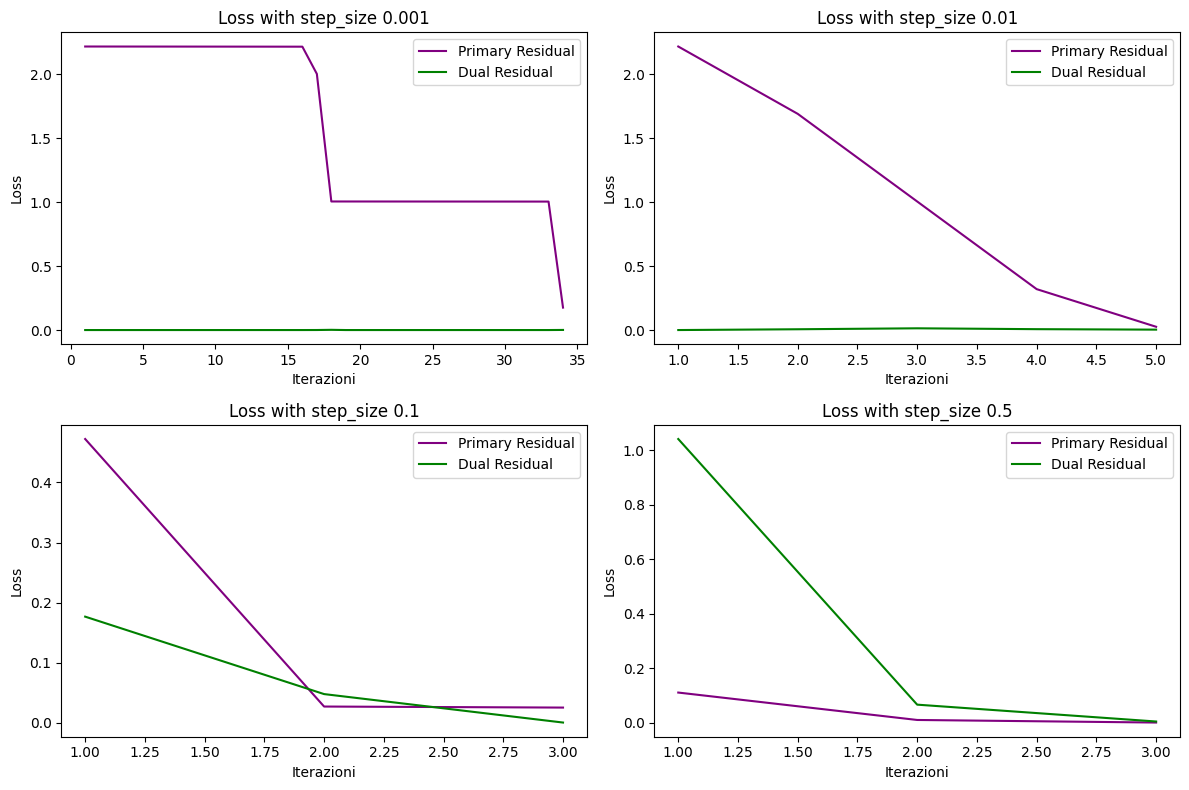

In [162]:
step_sizes = [0.001, 0.01, 0.1, 0.5]
l1_penalty = 0.1
agents = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, step_size in enumerate(step_sizes, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train, y_train, algo="distributed_admm", agents=agents)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with step_size {step_size}: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with step_size {step_size}: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test)

    r2 = r2_score(y_test, y_pred_distributed_admm)
    print(f"R^2 with step_size {step_size}: {r2}")
    
    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with step_size {step_size}')

plt.tight_layout()
plt.show()

Validation of l1_penalty parameter

Distributed ADMM time with l1_penalty 0.01: 0.0010287761688232422
Distributed ADMM iterations with l1_penalty 0.01: 3
R^2 with l1_penalty 0.01: 0.9826820515978547
Distributed ADMM time with l1_penalty 0.1: 0.002004384994506836
Distributed ADMM iterations with l1_penalty 0.1: 3
R^2 with l1_penalty 0.1: 0.9827325696067296
Distributed ADMM time with l1_penalty 1: 0.0
Distributed ADMM iterations with l1_penalty 1: 3
R^2 with l1_penalty 1: 0.9828257082541048
Distributed ADMM time with l1_penalty 10: 0.002965211868286133
Distributed ADMM iterations with l1_penalty 10: 8
R^2 with l1_penalty 10: 0.969602240850131


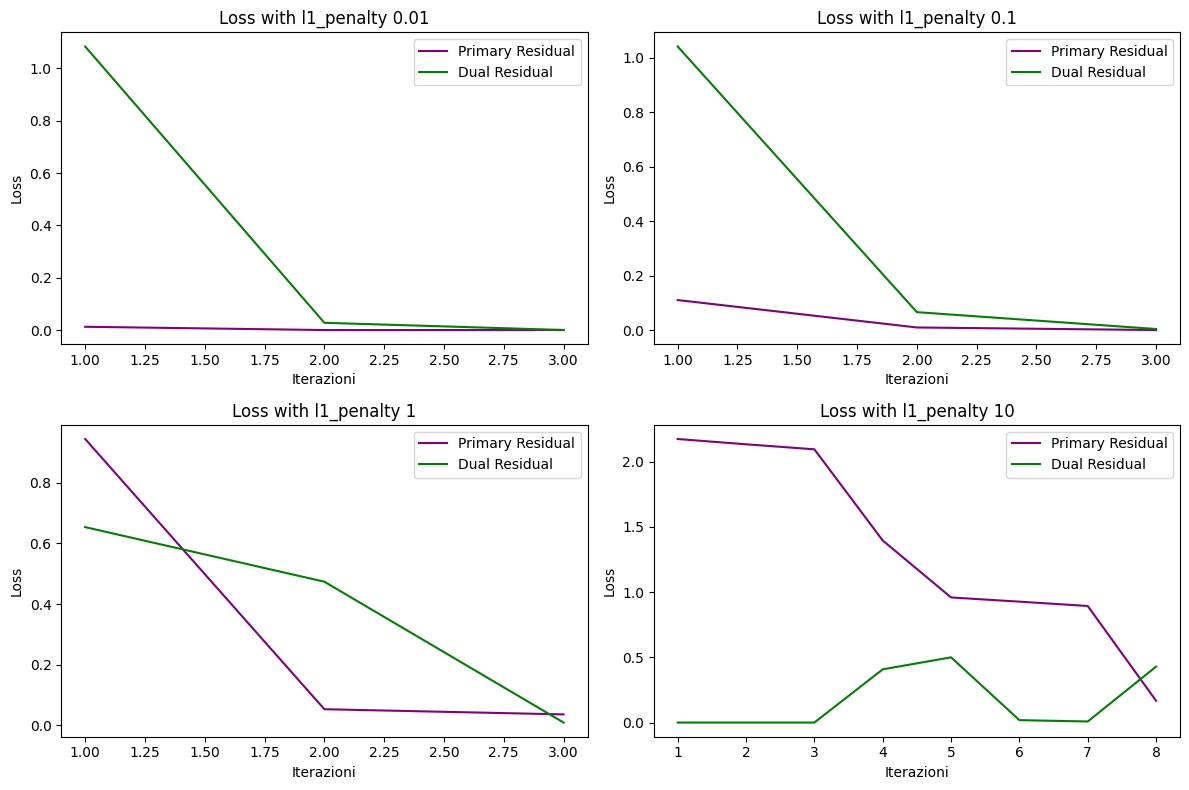

In [163]:
l1_penalties = [0.01, 0.1, 1, 10]
step_size = 0.5
agents = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, l1_penalty in enumerate(l1_penalties, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train, y_train, algo="distributed_admm", agents=agents)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with l1_penalty {l1_penalty}: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with l1_penalty {l1_penalty}: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test)

    r2 = r2_score(y_test, y_pred_distributed_admm)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with l1_penalty {l1_penalty}')

plt.tight_layout()
plt.show()

Validation of num_agents parameter

Distributed ADMM time with 3 agents: 0.0010313987731933594
Distributed ADMM iterations with 3 agents: 3
R^2 with 3 agents: 0.9827325696067296
Distributed ADMM time with 5 agents: 0.0020017623901367188
Distributed ADMM iterations with 5 agents: 3
R^2 with 5 agents: 0.9825430901844417
Distributed ADMM time with 10 agents: 0.0019998550415039062
Distributed ADMM iterations with 10 agents: 4
R^2 with 10 agents: 0.9823861212785205
Distributed ADMM time with 20 agents: 0.0029783248901367188
Distributed ADMM iterations with 20 agents: 5
R^2 with 20 agents: 0.9824148189621692


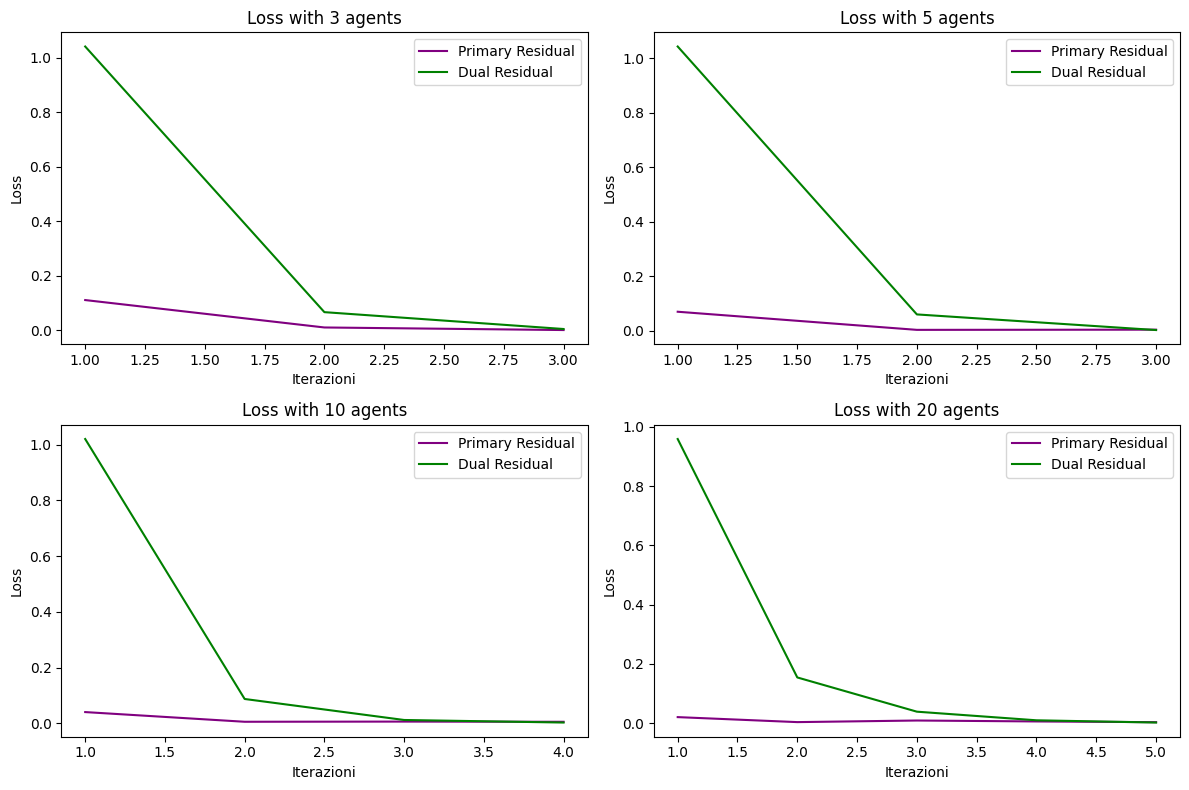

In [164]:
agents = [3, 5, 10, 20]
step_size = 0.5
l1_penalty = 0.1

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, agent in enumerate(agents, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train, y_train, algo="distributed_admm", agents=agent)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with {agent} agents: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with {agent} agents: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test)

    r2 = r2_score(y_test, y_pred_distributed_admm)
    print(f"R^2 with {agent} agents: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with {agent} agents')

plt.tight_layout()
plt.show()

### 2.2.4 Comparison of Lasso versions

Gradient Descent

GD time: 0.0034923553466796875
GD iterations: 58
R^2: 0.9824004921595375
MSE: 0.008384395844168653
MAE: 0.07052880190540556


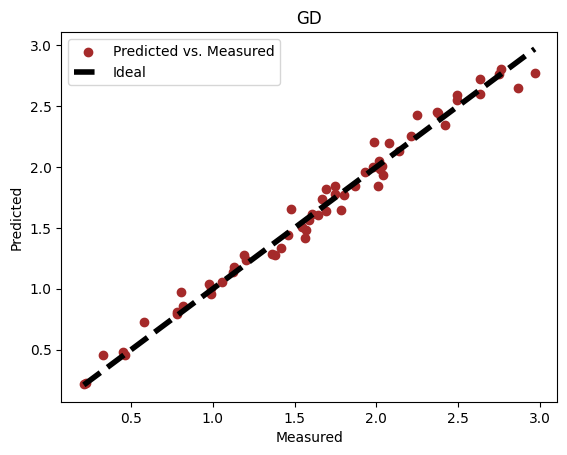

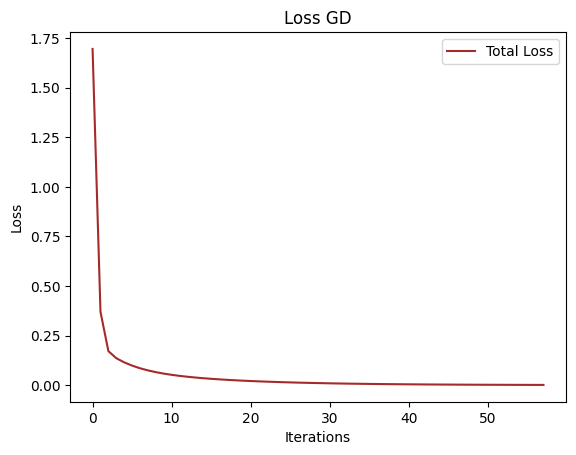

In [165]:
# parameters
step_size = 0.5
l1_penalty = 10

# GD
start_time = time.time()
lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_gd.fit(X_train, y_train, algo="gd")
gd_time = time.time() - start_time
print(f"GD time: {gd_time}")

iterations_gd = lasso_gd.iterations
print(f"GD iterations: {iterations_gd}")

y_pred_gd = lasso_gd.predict(X_test)

# metrics
r2_gd = r2_score(y_test, y_pred_gd)
print(f"R^2: {r2_gd}")

mse_gd = mean_squared_error(y_test, y_pred_gd)
print(f"MSE: {mse_gd}")
mae_gd = mean_absolute_error(y_test, y_pred_gd)
print(f"MAE: {mae_gd}")

# plots
prediction_plot(y_test, y_pred_gd, "GD")
loss_plot(lasso_gd.J, "Loss GD")

ADMM

ADMM time: 0.0
ADMM iterations: 3
R^2: 0.9825443979009756
MSE: 0.008315839228188088
MAE: 0.0699411533974265


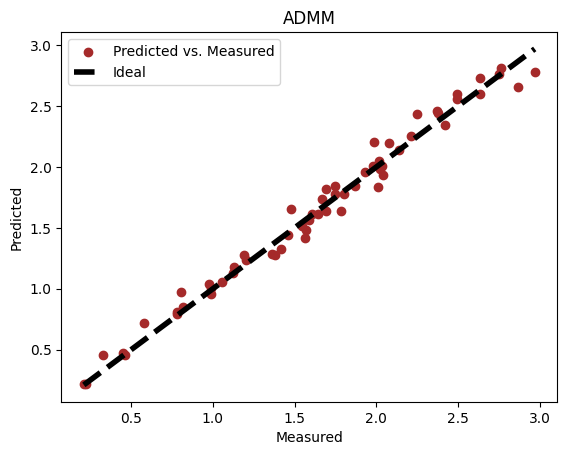

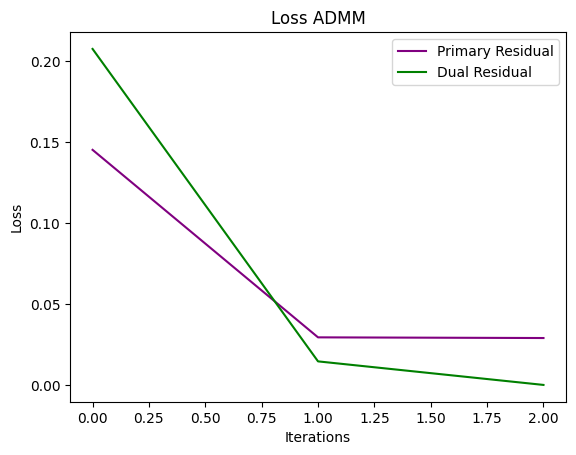

In [166]:
# parameters
step_size = 0.1
l1_penalty = 0.01

# ADMM
start_time = time.time()
lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_admm.fit(X_train, y_train, algo="admm")
admm_time = time.time() - start_time
print(f"ADMM time: {admm_time}")

iterations_admm = lasso_admm.iterations
print(f"ADMM iterations: {iterations_admm}")

y_pred_admm = lasso_admm.predict(X_test)

# metrics
r2_admm = r2_score(y_test, y_pred_admm)
print(f"R^2: {r2_admm}")

mse_admm = mean_squared_error(y_test, y_pred_admm)
print(f"MSE: {mse_admm}")
mae_admm = mean_absolute_error(y_test, y_pred_admm)
print(f"MAE: {mae_admm}")

# plots
prediction_plot(y_test, y_pred_admm, "ADMM")
loss_plot_admm(lasso_admm.J, "Loss ADMM")

Distributed ADMM

Distributed ADMM time: 0.006003141403198242
Distributed ADMM iterations: 5
R^2: 0.9824148189621692
MSE: 0.00837757056328384
MAE: 0.0702690700372072


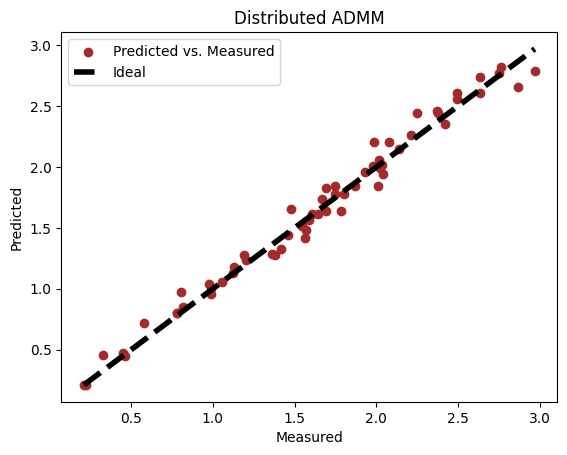

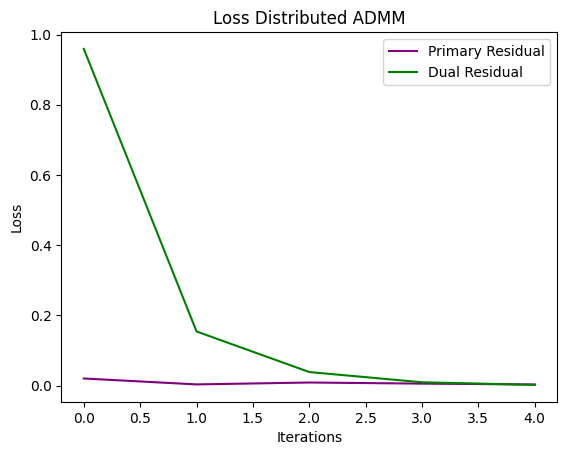

In [167]:
# parameters
step_size = 0.5
l1_penalty = 0.1
agents = 20

# Distributed ADMM
start_time = time.time()
lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_distributed_admm.fit(X_train, y_train, algo="distributed_admm", agents=agents)
distributed_admm_time = time.time() - start_time
print(f"Distributed ADMM time: {distributed_admm_time}")

iterations_distributed_admm = lasso_distributed_admm.iterations
print(f"Distributed ADMM iterations: {iterations_distributed_admm}")

y_pred_distributed_admm = lasso_distributed_admm.predict(X_test)

# metrics
r2_distributed_admm = r2_score(y_test, y_pred_distributed_admm)
print(f"R^2: {r2_distributed_admm}")

mse_distributed_admm = mean_squared_error(y_test, y_pred_distributed_admm)
print(f"MSE: {mse_distributed_admm}")
mae_distributed_admm = mean_absolute_error(y_test, y_pred_distributed_admm)
print(f"MAE: {mae_distributed_admm}")

# plots
prediction_plot(y_test, y_pred_distributed_admm, "Distributed ADMM")
loss_plot_admm(lasso_distributed_admm.J, "Loss Distributed ADMM")

# 3- Test on second synthetically generated dataset

## 3.1- Dataset generation

A second, more complex dataset is generated

In [188]:
n_num_features = 8
n_cat_features = 2
n_samples = 2000

X_numeric = np.column_stack((
    np.random.normal(loc=7, scale=2, size=(n_samples, 1)),  
    np.random.uniform(low=2, high=12, size=(n_samples, 1)),  
    np.random.exponential(scale=3, size=(n_samples, 1)),  
    np.random.poisson(lam=4, size=(n_samples, 1)),  
    np.random.gamma(shape=3, scale=2, size=(n_samples, 1)),  
    np.random.logistic(loc=-2, scale=1, size=(n_samples, 1)),  
    np.random.chisquare(df=3, size=(n_samples, 1)),  
    np.random.power(a=4, size=(n_samples, 1))                                       
))

X_categorical = np.random.choice([1, 2, 3, 4], size=(n_samples, n_cat_features))

X = np.concatenate((X_numeric, X_categorical), axis=1)

In [189]:
true_weights_numeric = np.random.uniform(-10, 10, n_num_features)

true_weights_categorical = np.random.uniform(-2, 2, n_cat_features)

y = (X_numeric @ true_weights_numeric  + X_categorical @ true_weights_categorical  + 14 + 17 * np.random.randn(n_samples) + np.sin(0.15 * X_numeric[:, 0]) + np.exp(0.2 * X_numeric[:, 1]) + np.cos(0.3 * X_numeric[:, 2]) * X_categorical[:, 0] + np.tanh(0.25 * X_numeric[:, 4]) * X_categorical[:, 1] + 0.25 * np.random.uniform(-10, 71, n_samples))

Visualize distribution of data

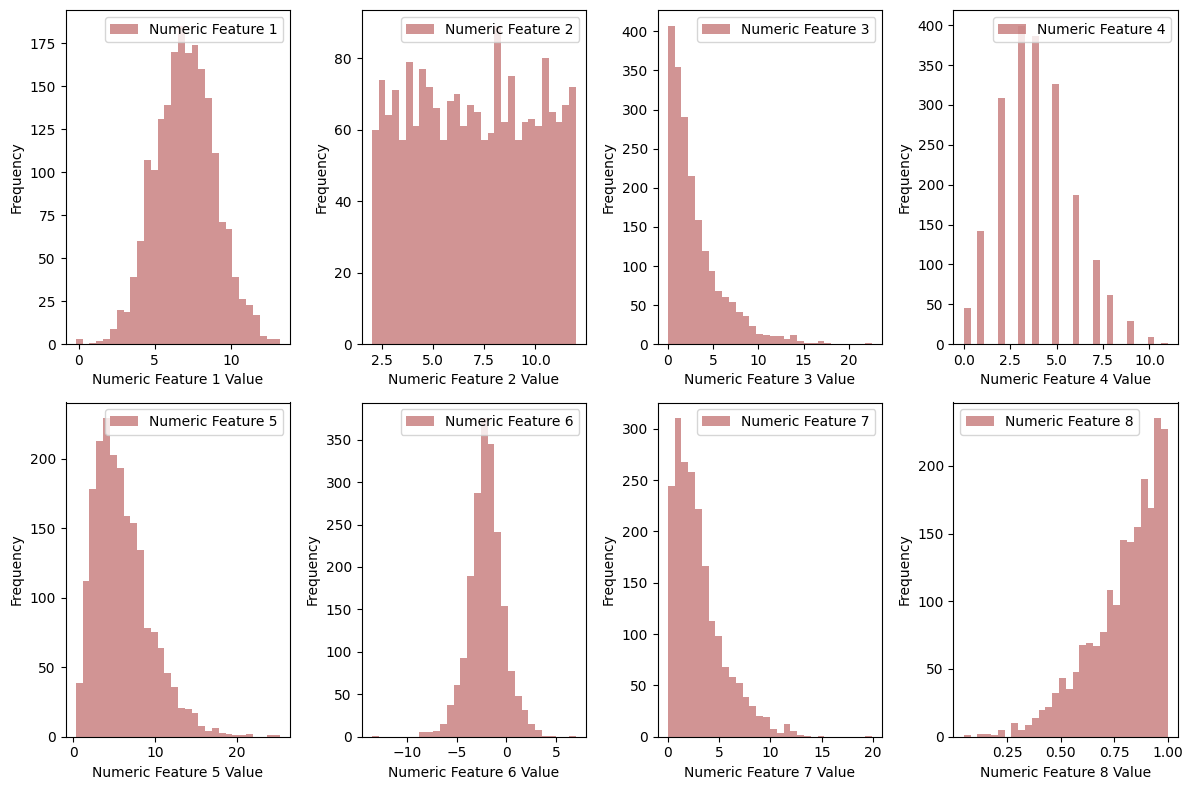

In [190]:
fig, axes = plt.subplots(nrows=2, ncols=n_num_features // 2, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.hist(X_numeric[:, i], bins=30, alpha=0.5, label=f'Numeric Feature {i + 1}', color='brown')
    ax.legend()
    ax.set_xlabel(f'Numeric Feature {i + 1} Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

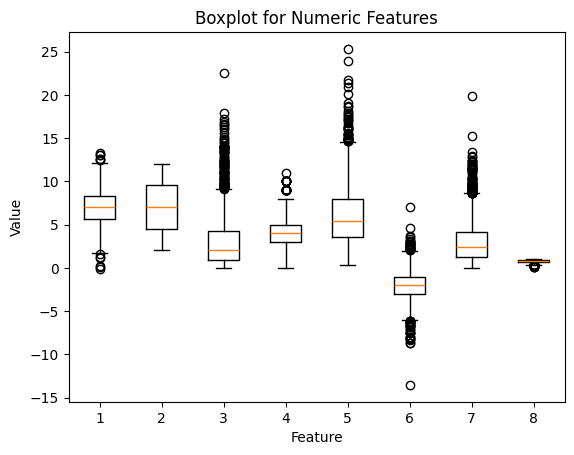

In [191]:
plt.boxplot(X_numeric)
plt.xlabel('Feature')
plt.ylabel('Value')
plt.title('Boxplot for Numeric Features')
plt.show()

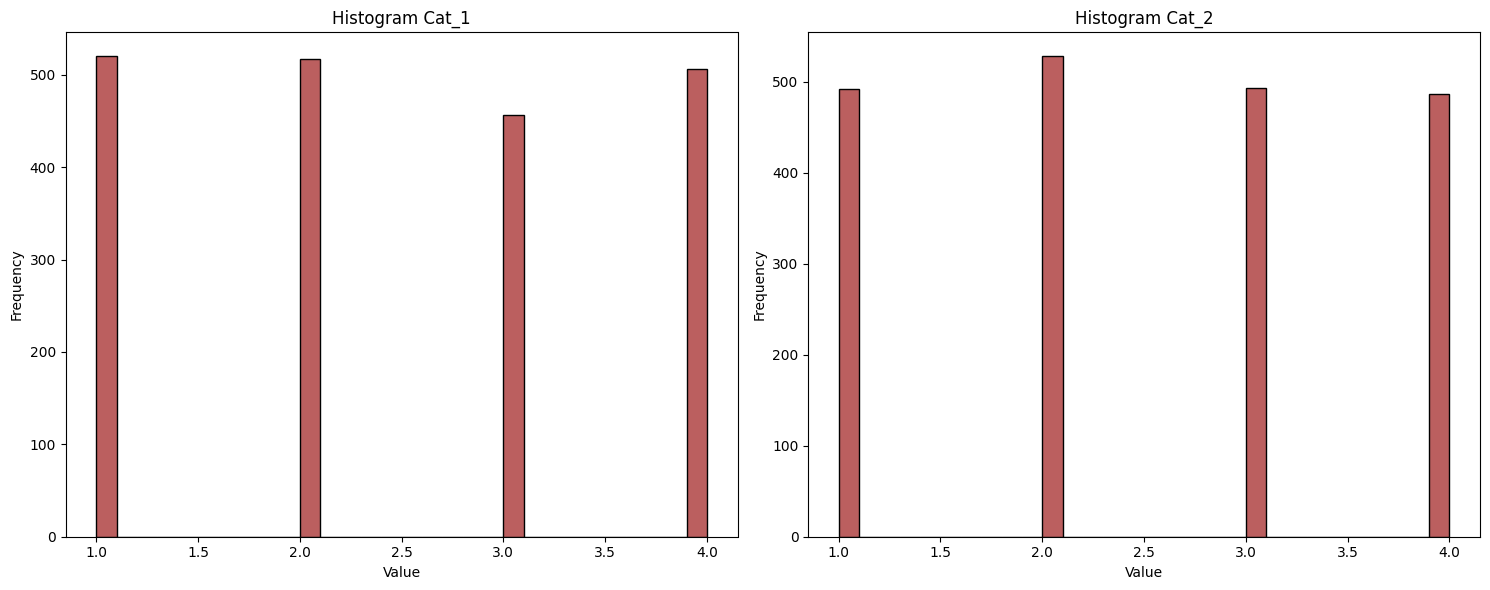

In [192]:
df_cat = pd.DataFrame(X_categorical, columns=[f'Cat_{i + 1}' for i in range(n_cat_features)])

plt.figure(figsize=(15, 6))
for i in range(n_cat_features):
    plt.subplot(1, n_cat_features, i + 1)
    sns.histplot(df_cat[f'Cat_{i + 1}'], bins=30, color='brown', edgecolor='black')
    plt.title(f'Histogram Cat_{i + 1}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Visualize distribution of target variable

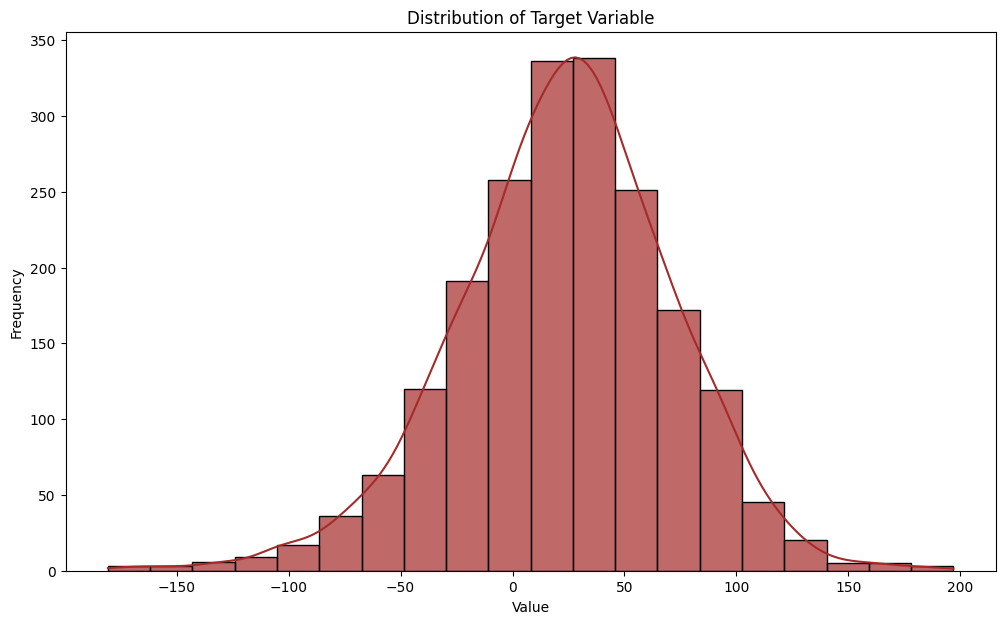

In [193]:
plt.figure(figsize=(12, 7))
sns.histplot(y, bins=20, kde=True, color='brown', alpha=0.7)
plt.title('Distribution of Target Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [194]:
X_one_hot = pd.get_dummies(df_cat, columns=df_cat.columns, drop_first=True).values

X = np.concatenate((X_numeric, X_one_hot), axis=1)

Division of the dataset into train set and test set

In [195]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42)

Data normalisation

In [196]:
scaler = MinMaxScaler()
X_train_2 = scaler.fit_transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)

In [197]:
# parameters
step_size = 0.01
l1_penalty = 0.1
max_iterations = 100000
tolerance = 1e-3

## 3.2- Training and testing the model on the dataset evaluating the impact of the choice of parameters

### 3.2.1- Lasso Gradient Descent

Validation of step_size parameter

In [198]:
step_sizes = [0.001, 0.01, 0.1, 0.5]

for step_size in step_sizes:
    start_time = time.time()
    
    lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_gd.fit(X_train_2, y_train_2, algo="gd")
    gd_time = time.time() - start_time
    print(f"GD time with step_size {step_size}: {gd_time}")

    iterations_gd = lasso_gd.iterations
    print(f"GD iterations with step_size {step_size}: {iterations_gd}")
    
    y_pred_gd = lasso_gd.predict(X_test_2)

    r2 = r2_score(y_test_2, y_pred_gd)
    print(f"R^2 with step_size {step_size}: {r2}")


GD time with step_size 0.001: 18.934195280075073
GD iterations with step_size 0.001: 68866
R^2 with step_size 0.001: 0.8256735522680634
GD time with step_size 0.01: 3.6815438270568848
GD iterations with step_size 0.01: 14020
R^2 with step_size 0.01: 0.8369716888976504
GD time with step_size 0.1: 0.5587904453277588
GD iterations with step_size 0.1: 2149
R^2 with step_size 0.1: 0.8376032277408818
GD time with step_size 0.5: 0.14200258255004883
GD iterations with step_size 0.5: 557
R^2 with step_size 0.5: 0.8376691212054397


Validation of l1_penalty parameter

In [199]:
step_size = 0.5
l1_penalties = [0.01, 0.1, 1, 10]

for l1_penalty in l1_penalties:
    start_time = time.time()
    
    lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_gd.fit(X_train_2, y_train_2, algo="gd")
    gd_time = time.time() - start_time
    print(f"GD time with l1_penalty {l1_penalty}: {gd_time}")

    iterations_gd = lasso_gd.iterations
    print(f"GD iterations with l1_penalty {l1_penalty}: {iterations_gd}")
    
    y_pred_gd = lasso_gd.predict(X_test_2)

    r2 = r2_score(y_test_2, y_pred_gd)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

GD time with l1_penalty 0.01: 0.18399858474731445
GD iterations with l1_penalty 0.01: 557
R^2 with l1_penalty 0.01: 0.8376680211377954
GD time with l1_penalty 0.1: 0.16536641120910645
GD iterations with l1_penalty 0.1: 557
R^2 with l1_penalty 0.1: 0.8376691212054397
GD time with l1_penalty 1: 0.15618348121643066
GD iterations with l1_penalty 1: 557
R^2 with l1_penalty 1: 0.8376801061800716
GD time with l1_penalty 10: 0.14099955558776855
GD iterations with l1_penalty 10: 555
R^2 with l1_penalty 10: 0.8377795983762074


### 3.2.2- Lasso ADMM

Validation of step_size parameter

ADMM time with step_size 0.001: 0.002039194107055664
ADMM iterations with step_size 0.001: 4
R^2 with step_size 0.001: 0.8381995058246632
ADMM time with step_size 0.01: 0.0020017623901367188
ADMM iterations with step_size 0.01: 4
R^2 with step_size 0.01: 0.8381990821628996
ADMM time with step_size 0.1: 0.002005338668823242
ADMM iterations with step_size 0.1: 3
R^2 with step_size 0.1: 0.8381990808567126
ADMM time with step_size 0.5: 0.001971006393432617
ADMM iterations with step_size 0.5: 4
R^2 with step_size 0.5: 0.8381990855458835


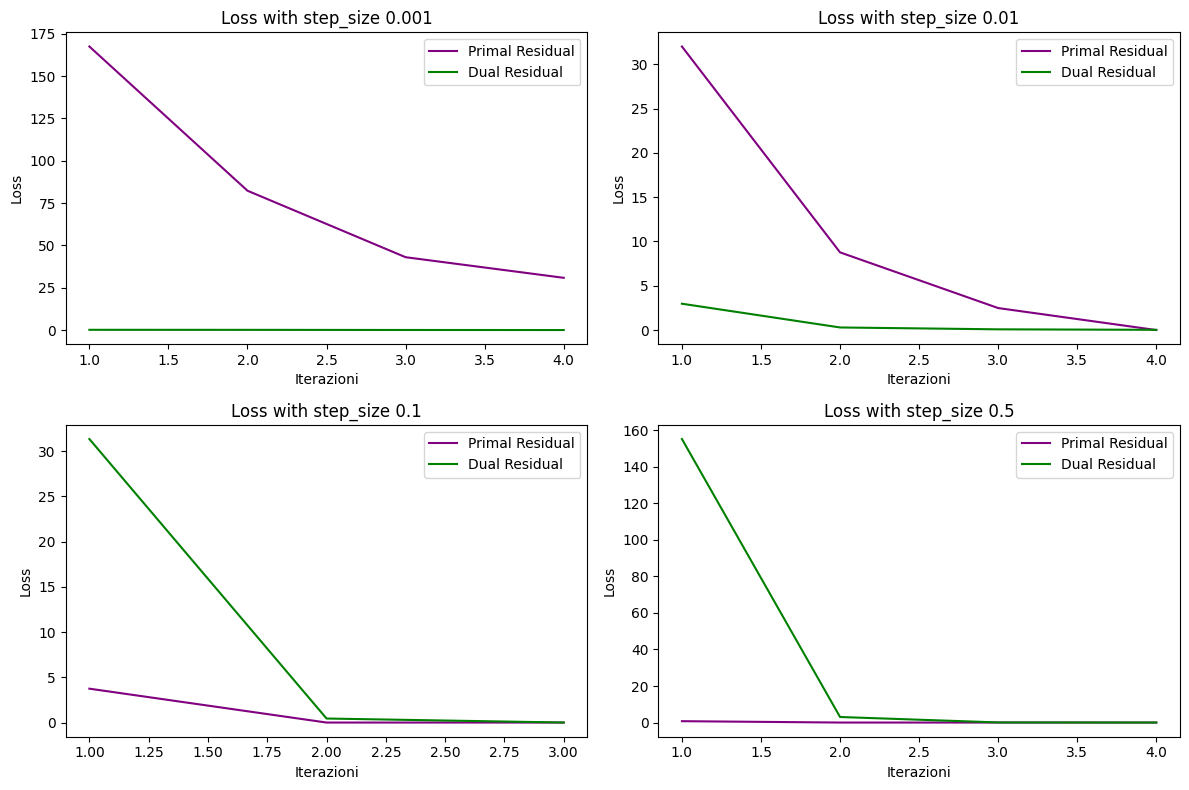

In [200]:
l1_penalty = 0.1
step_sizes = [0.001, 0.01, 0.1, 0.5]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, step_size in enumerate(step_sizes, 1):
    start_time = time.time()

    lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_admm.fit(X_train_2, y_train_2, algo="admm")
    admm_time = time.time() - start_time
    print(f"ADMM time with step_size {step_size}: {admm_time}")

    iterations_admm = lasso_admm.iterations
    print(f"ADMM iterations with step_size {step_size}: {iterations_admm}")

    y_pred_admm = lasso_admm.predict(X_test_2)

    r2 = 1 - np.mean((y_test_2 - y_pred_admm) ** 2) / np.var(y_test_2)
    print(f"R^2 with step_size {step_size}: {r2}")

    while i > axs.size:
        axs = np.append(axs, plt.subplots(2, 2, figsize=(12, 8))[1], axis=0)

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_admm_val(axs[row, col], lasso_admm.J, f'Loss with step_size {step_size}')

plt.tight_layout()

plt.show()

Validation of l1_penalty parameter

ADMM time with l1_penalty 0.01: 0.001972198486328125
ADMM iterations with l1_penalty 0.01: 3
R^2 with l1_penalty 0.01: 0.8382007306797934
ADMM time with l1_penalty 0.1: 0.0009992122650146484
ADMM iterations with l1_penalty 0.1: 3
R^2 with l1_penalty 0.1: 0.8381990808567126
ADMM time with l1_penalty 1: 0.0020215511322021484
ADMM iterations with l1_penalty 1: 4
R^2 with l1_penalty 1: 0.8381825097608191
ADMM time with l1_penalty 10: 0.001999378204345703
ADMM iterations with l1_penalty 10: 5
R^2 with l1_penalty 10: 0.8380385570810059


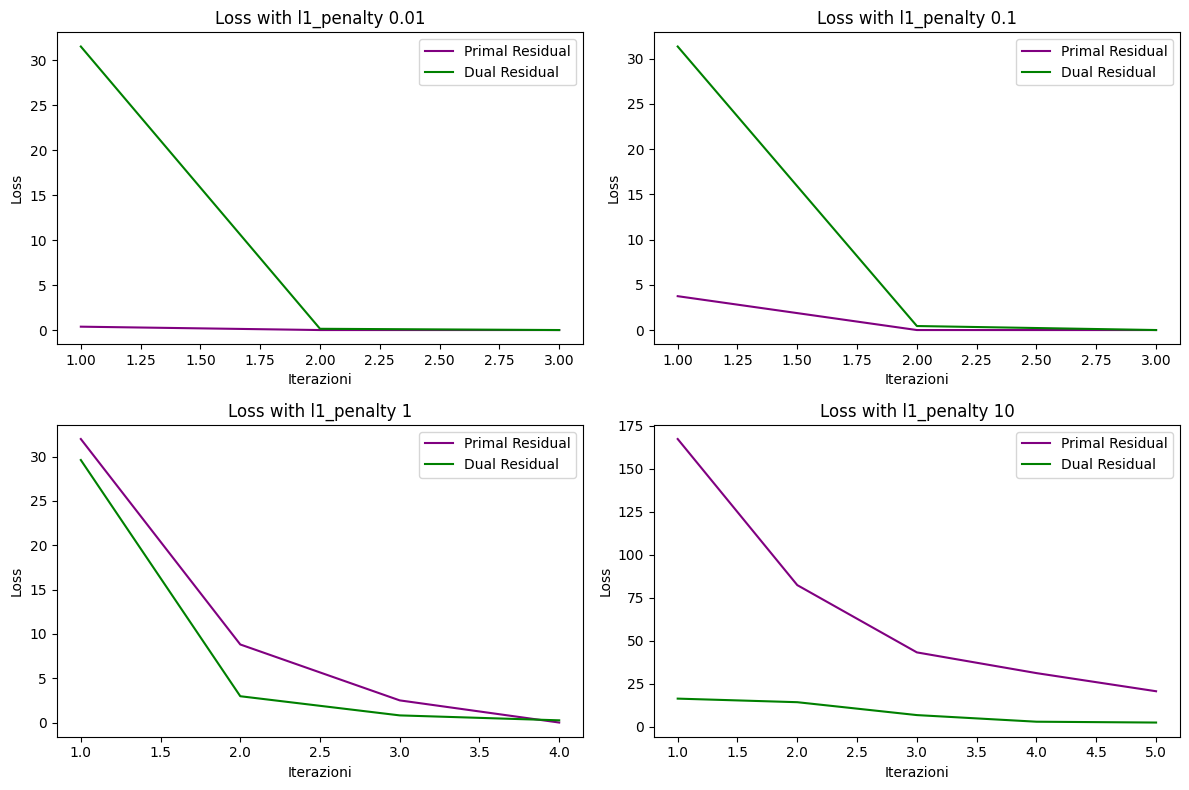

In [210]:
step_size = 0.1
l1_penalties = [0.01, 0.1, 1, 10]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, l1_penalty in enumerate(l1_penalties, 1):
    start_time = time.time()
    
    lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_admm.fit(X_train_2, y_train_2, algo="admm")
    admm_time = time.time() - start_time
    print(f"ADMM time with l1_penalty {l1_penalty}: {admm_time}")

    iterations_admm = lasso_admm.iterations
    print(f"ADMM iterations with l1_penalty {l1_penalty}: {iterations_admm}")
    
    y_pred_admm = lasso_admm.predict(X_test_2)

    r2 = r2_score(y_test_2, y_pred_admm)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

    while i > axs.size:
        axs = np.append(axs, plt.subplots(2, 2, figsize=(12, 8))[1], axis=0)

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_admm_val(axs[row, col], lasso_admm.J, f'Loss with l1_penalty {l1_penalty}')

plt.tight_layout()

plt.show()

### 3.2.3- Lasso Distributed ADMM

Validation of step_size parameter

Distributed ADMM time with step_size 0.001: 0.0020058155059814453
Distributed ADMM iterations with step_size 0.001: 3
R^2 with step_size 0.001: 0.8385080446338853
Distributed ADMM time with step_size 0.01: 0.0010001659393310547
Distributed ADMM iterations with step_size 0.01: 3
R^2 with step_size 0.01: 0.8385078350330138
Distributed ADMM time with step_size 0.1: 0.0010020732879638672
Distributed ADMM iterations with step_size 0.1: 3
R^2 with step_size 0.1: 0.8385064499590253
Distributed ADMM time with step_size 0.5: 0.002996206283569336
Distributed ADMM iterations with step_size 0.5: 4
R^2 with step_size 0.5: 0.8384982185354564


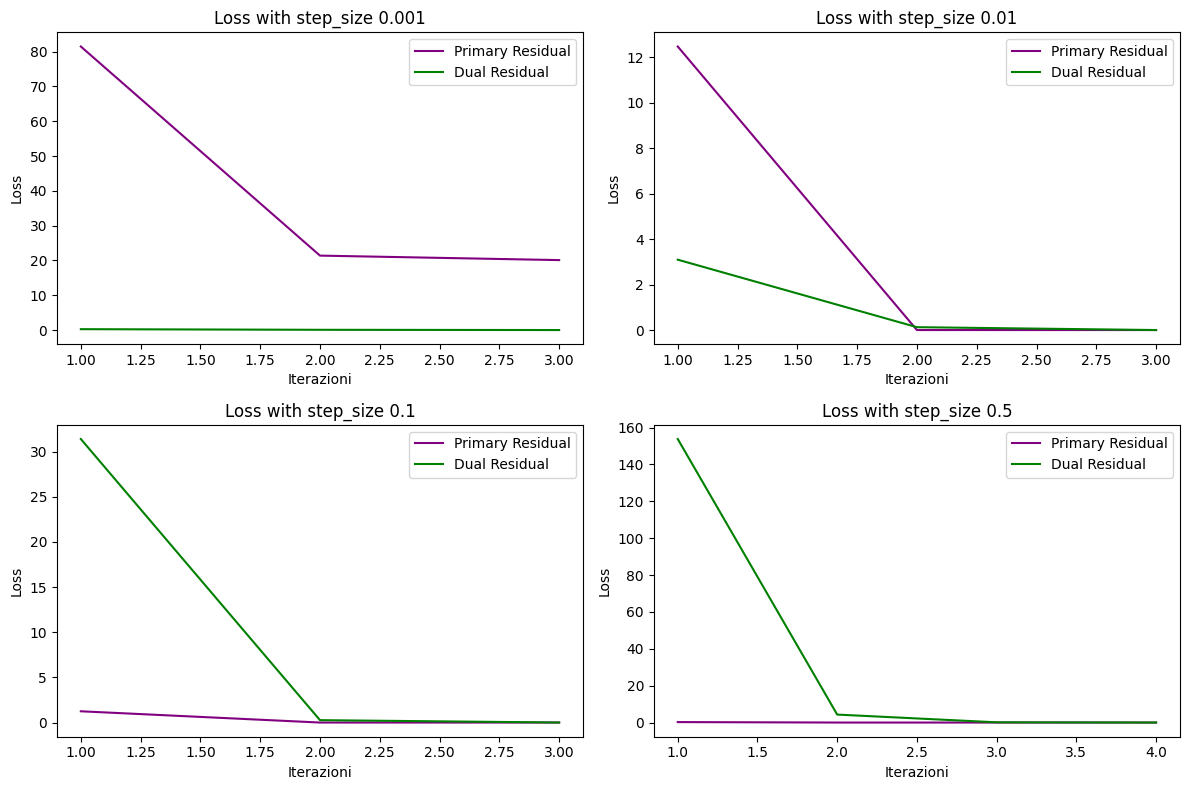

In [214]:
step_sizes = [0.001, 0.01, 0.1, 0.5]
l1_penalty = 0.1
agents = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, step_size in enumerate(step_sizes, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train_2, y_train_2, algo="distributed_admm", agents=agents)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with step_size {step_size}: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with step_size {step_size}: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_2)

    r2 = r2_score(y_test_2, y_pred_distributed_admm)
    print(f"R^2 with step_size {step_size}: {r2}")
    
    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with step_size {step_size}')

plt.tight_layout()

plt.show()

Validation of l1_penalty parameter

Distributed ADMM time with l1_penalty 0.01: 0.0010008811950683594
Distributed ADMM iterations with l1_penalty 0.01: 3
R^2 with l1_penalty 0.01: 0.8385086882263955
Distributed ADMM time with l1_penalty 0.1: 0.0019876956939697266
Distributed ADMM iterations with l1_penalty 0.1: 3
R^2 with l1_penalty 0.1: 0.8385078350330138
Distributed ADMM time with l1_penalty 1: 0.0019974708557128906
Distributed ADMM iterations with l1_penalty 1: 3
R^2 with l1_penalty 1: 0.8384999926760801
Distributed ADMM time with l1_penalty 10: 0.005999326705932617
Distributed ADMM iterations with l1_penalty 10: 13
R^2 with l1_penalty 10: 0.838434532972012


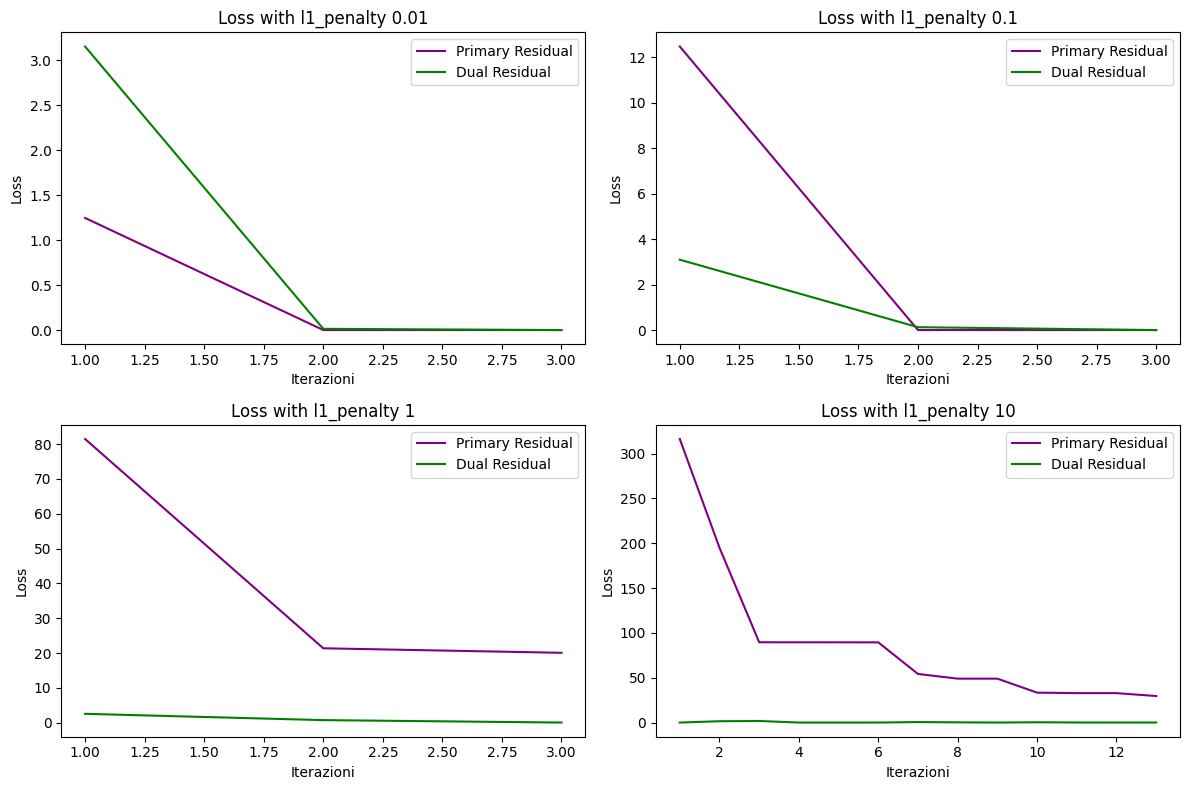

In [215]:
step_size = 0.01
l1_penalties = [0.01, 0.1, 1, 10]
agents = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, l1_penalty in enumerate(l1_penalties, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train_2, y_train_2, algo="distributed_admm", agents=agents)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with l1_penalty {l1_penalty}: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with l1_penalty {l1_penalty}: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_2)

    r2 = r2_score(y_test_2, y_pred_distributed_admm)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with l1_penalty {l1_penalty}')

plt.tight_layout()
plt.show()

Validation of num_agents parameter

Distributed ADMM time with 3 agents: 0.0020372867584228516
Distributed ADMM iterations with 3 agents: 3
R^2 with 3 agents: 0.8385086882263955
Distributed ADMM time with 5 agents: 0.0020008087158203125
Distributed ADMM iterations with 5 agents: 3
R^2 with 5 agents: 0.8375345540202517
Distributed ADMM time with 10 agents: 0.002980470657348633
Distributed ADMM iterations with 10 agents: 3
R^2 with 10 agents: 0.8379748823692814
Distributed ADMM time with 20 agents: 0.0019931793212890625
Distributed ADMM iterations with 20 agents: 3
R^2 with 20 agents: 0.8383301628990563


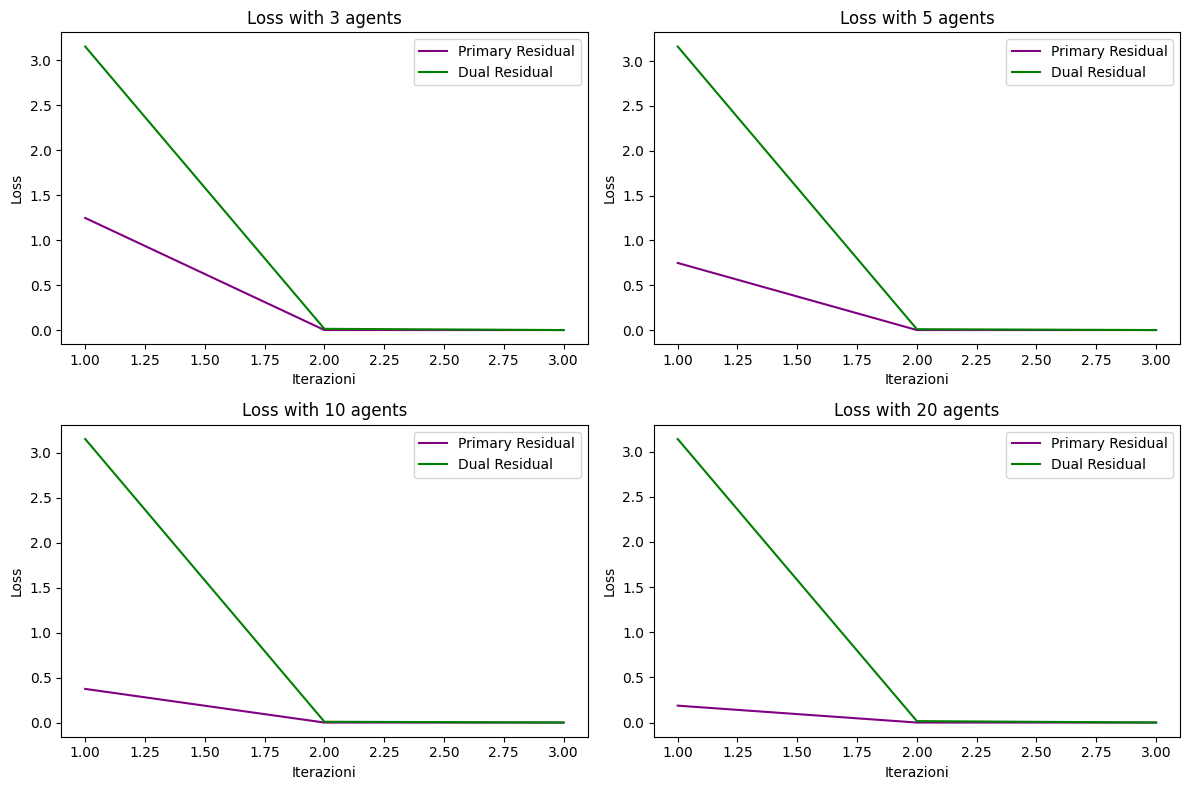

In [217]:
step_size = 0.01
l1_penalty = 0.01
agents = [3, 5, 10, 20]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, agent in enumerate(agents, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train_2, y_train_2, algo="distributed_admm", agents=agent)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with {agent} agents: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with {agent} agents: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_2)

    r2 = r2_score(y_test_2, y_pred_distributed_admm)
    print(f"R^2 with {agent} agents: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with {agent} agents')

plt.tight_layout()
plt.show()

### 3.2.4 Comparison of Lasso versions

Gradient Descent

GD time: 0.2819993495941162
GD iterations: 555
R^2: 0.8377795983762074
MSE: 415.61588043167257
MAE: 15.897827319560083


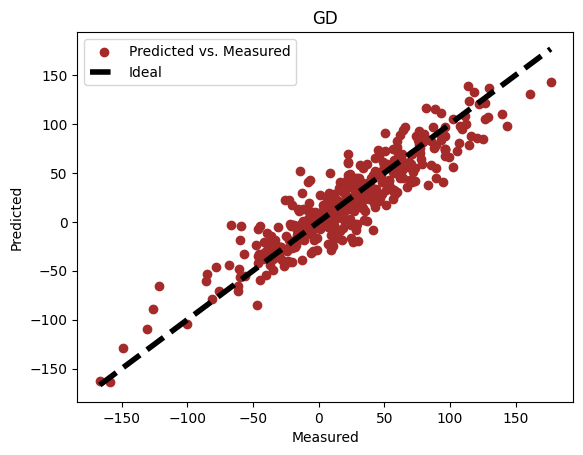

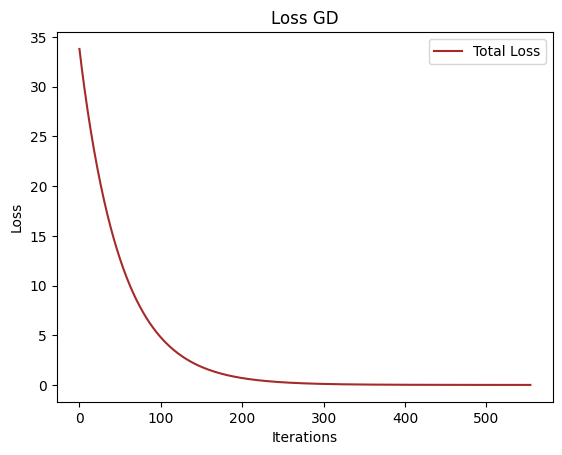

In [207]:
# parameters
step_size = 0.5
l1_penalty = 10

# GD
start_time = time.time()
lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_gd.fit(X_train_2, y_train_2, algo="gd")
gd_time = time.time() - start_time
print(f"GD time: {gd_time}")

iterations_gd = lasso_gd.iterations
print(f"GD iterations: {iterations_gd}")

y_pred_gd = lasso_gd.predict(X_test_2)

# metrics
r2_gd = r2_score(y_test_2, y_pred_gd)
print(f"R^2: {r2_gd}")

mse_gd = mean_squared_error(y_test_2, y_pred_gd)
print(f"MSE: {mse_gd}")
mae_gd = mean_absolute_error(y_test_2, y_pred_gd)
print(f"MAE: {mae_gd}")

# plots
prediction_plot(y_test_2, y_pred_gd, "GD")
loss_plot(lasso_gd.J, "Loss GD")

ADMM

ADMM time: 0.022010087966918945
ADMM iterations: 3
R^2: 0.8381990808567126
MSE: 414.5411476686191
MAE: 15.863227659633118


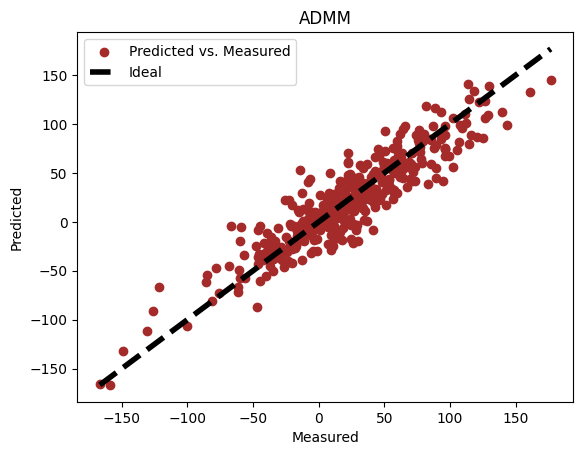

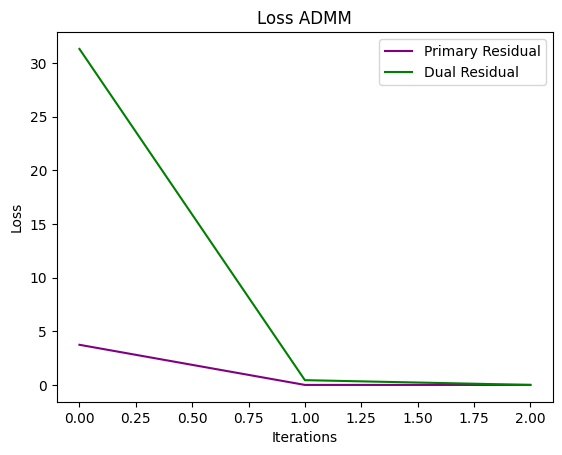

In [211]:
# parameters
step_size = 0.1
l1_penalty = 0.1

# ADMM
start_time = time.time()
lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_admm.fit(X_train_2, y_train_2, algo="admm")
admm_time = time.time() - start_time
print(f"ADMM time: {admm_time}")

iterations_admm = lasso_admm.iterations
print(f"ADMM iterations: {iterations_admm}")

y_pred_admm = lasso_admm.predict(X_test_2)

# metrics
r2_admm = r2_score(y_test_2, y_pred_admm)
print(f"R^2: {r2_admm}")

mse_admm = mean_squared_error(y_test_2, y_pred_admm)
print(f"MSE: {mse_admm}")
mae_admm = mean_absolute_error(y_test_2, y_pred_admm)
print(f"MAE: {mae_admm}")

# plots
prediction_plot(y_test_2, y_pred_admm, "ADMM")
loss_plot_admm(lasso_admm.J, "Loss ADMM")

Distributed ADMM

Distributed ADMM time: 0.0028638839721679688
Distributed ADMM iterations: 3
R^2: 0.8385086882263955
MSE: 413.74791982396533
MAE: 15.854998520399183


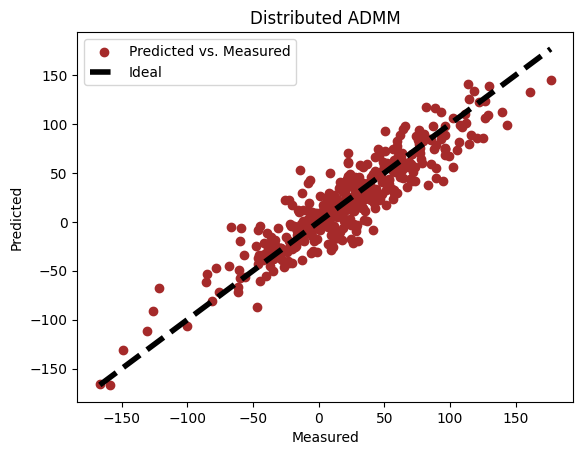

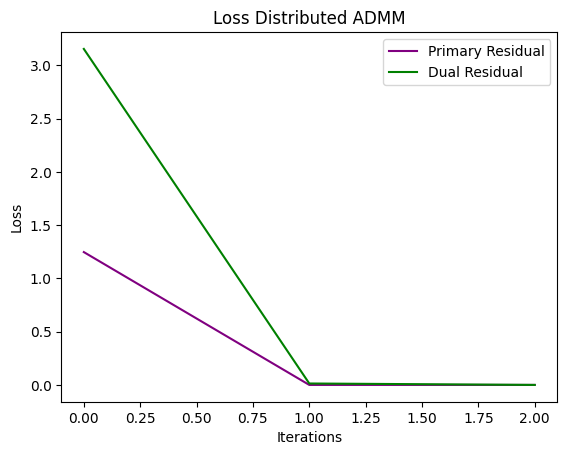

In [218]:
# parameters
step_size = 0.01
l1_penalty = 0.01
agents = 3

# Distributed ADMM
start_time = time.time()
lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_distributed_admm.fit(X_train_2, y_train_2, algo="distributed_admm", agents=agents)
distributed_admm_time = time.time() - start_time
print(f"Distributed ADMM time: {distributed_admm_time}")

iterations_distributed_admm = lasso_distributed_admm.iterations
print(f"Distributed ADMM iterations: {iterations_distributed_admm}")

y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_2)

# metrics
r2_distributed_admm = r2_score(y_test_2, y_pred_distributed_admm)
print(f"R^2: {r2_distributed_admm}")

mse_distributed_admm = mean_squared_error(y_test_2, y_pred_distributed_admm)
print(f"MSE: {mse_distributed_admm}")
mae_distributed_admm = mean_absolute_error(y_test_2, y_pred_distributed_admm)
print(f"MAE: {mae_distributed_admm}")

# plots
prediction_plot(y_test_2, y_pred_distributed_admm, "Distributed ADMM")
loss_plot_admm(lasso_distributed_admm.J, "Loss Distributed ADMM")

# 4- Test on real dataset

## 4.1- Dataset import

An already pre-processed and cleaned dataset is imported

In [219]:
df_real = pd.read_csv('cleaned_concrete_data.csv')

In [220]:
print(df_real.head())
print(df_real.shape)

   cement   slag     ash  water  superplasticizer  coarse    fine  age  \
0  380.00    0.0    0.00  228.0              0.00   932.0  670.00   90   
1  332.50  142.5    0.00  228.0              0.00   932.0  594.00    7   
2  246.83    0.0  125.08  143.3             11.99  1086.8  800.89  100   
3  236.00    0.0    0.00  194.0              0.00   968.0  885.00   28   
4  236.00    0.0    0.00  193.0              0.00   968.0  885.00    7   

    strength  
0  52.908320  
1  30.275581  
2  66.424118  
3  18.415904  
4   9.990507  
(1005, 9)


Division of the dataset into train set and test set

In [221]:
X_real = df_real.drop('strength', axis=1).values
y_real = df_real['strength'].values

X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y_real, test_size=0.2, random_state=42)

Data normalisation

In [222]:
scaler = MinMaxScaler()
X_train_real = scaler.fit_transform(X_train_real)
X_test_real = scaler.transform(X_test_real)

In [223]:
# parameters
step_size = 0.01
l1_penalty = 0.1
max_iterations = 100000
tolerance = 1e-3

## 4.2- Training and testing the model on the dataset evaluating the impact of the choice of parameters

### 4.2.1- Lasso Gradient Descent

Validation of step_size parameter

In [224]:
step_sizes = [0.001, 0.01, 0.1, 0.5]

for step_size in step_sizes:
    start_time = time.time()
    
    lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_gd.fit(X_train_real, y_train_real, algo="gd")
    gd_time = time.time() - start_time
    print(f"GD time with step_size {step_size}: {gd_time}")

    iterations_gd = lasso_gd.iterations
    print(f"GD iterations with step_size {step_size}: {iterations_gd}")
    
    y_pred_gd = lasso_gd.predict(X_test_real)

    r2 = r2_score(y_test_real, y_pred_gd)
    print(f"R^2 with step_size {step_size}: {r2}")

GD time with step_size 0.001: 0.9506847858428955
GD iterations with step_size 0.001: 19652
R^2 with step_size 0.001: 0.5566210274607339
GD time with step_size 0.01: 0.4954705238342285
GD iterations with step_size 0.01: 10922
R^2 with step_size 0.01: 0.6155771242194971
GD time with step_size 0.1: 0.1329665184020996
GD iterations with step_size 0.1: 2594
R^2 with step_size 0.1: 0.6209820576587446
GD time with step_size 0.5: 0.039034128189086914
GD iterations with step_size 0.5: 727
R^2 with step_size 0.5: 0.6213591700312899


Validation of l1_penalty parameter

In [225]:
step_size = 0.5
l1_penalties = [0.01, 0.1, 1, 10]

for l1_penalty in l1_penalties:
    start_time = time.time()
    
    lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_gd.fit(X_train_real, y_train_real, algo="gd")
    gd_time = time.time() - start_time
    print(f"GD time with l1_penalty {l1_penalty}: {gd_time}")

    iterations_gd = lasso_gd.iterations
    print(f"GD iterations with l1_penalty {l1_penalty}: {iterations_gd}")
    
    y_pred_gd = lasso_gd.predict(X_test_real)

    r2 = r2_score(y_test_real, y_pred_gd)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

GD time with l1_penalty 0.01: 0.041094303131103516
GD iterations with l1_penalty 0.01: 727
R^2 with l1_penalty 0.01: 0.6213498245301308
GD time with l1_penalty 0.1: 0.03399991989135742
GD iterations with l1_penalty 0.1: 727
R^2 with l1_penalty 0.1: 0.6213591700312899
GD time with l1_penalty 1: 0.0359959602355957
GD iterations with l1_penalty 1: 728
R^2 with l1_penalty 1: 0.6214530878718998
GD time with l1_penalty 10: 0.048001766204833984
GD iterations with l1_penalty 10: 732
R^2 with l1_penalty 10: 0.6222018084294475


### 4.2.2 Lasso ADMM

Validation of step_size parameter

ADMM time with step_size 0.001: 0.001001119613647461
ADMM iterations with step_size 0.001: 11
R^2 with step_size 0.001: 0.6237980771552829
ADMM time with step_size 0.01: 0.0009665489196777344
ADMM iterations with step_size 0.01: 4
R^2 with step_size 0.01: 0.6237944166975957
ADMM time with step_size 0.1: 0.0009715557098388672
ADMM iterations with step_size 0.1: 3
R^2 with step_size 0.1: 0.6237944773701208
ADMM time with step_size 0.5: 0.0009853839874267578
ADMM iterations with step_size 0.5: 4
R^2 with step_size 0.5: 0.6237938272844203


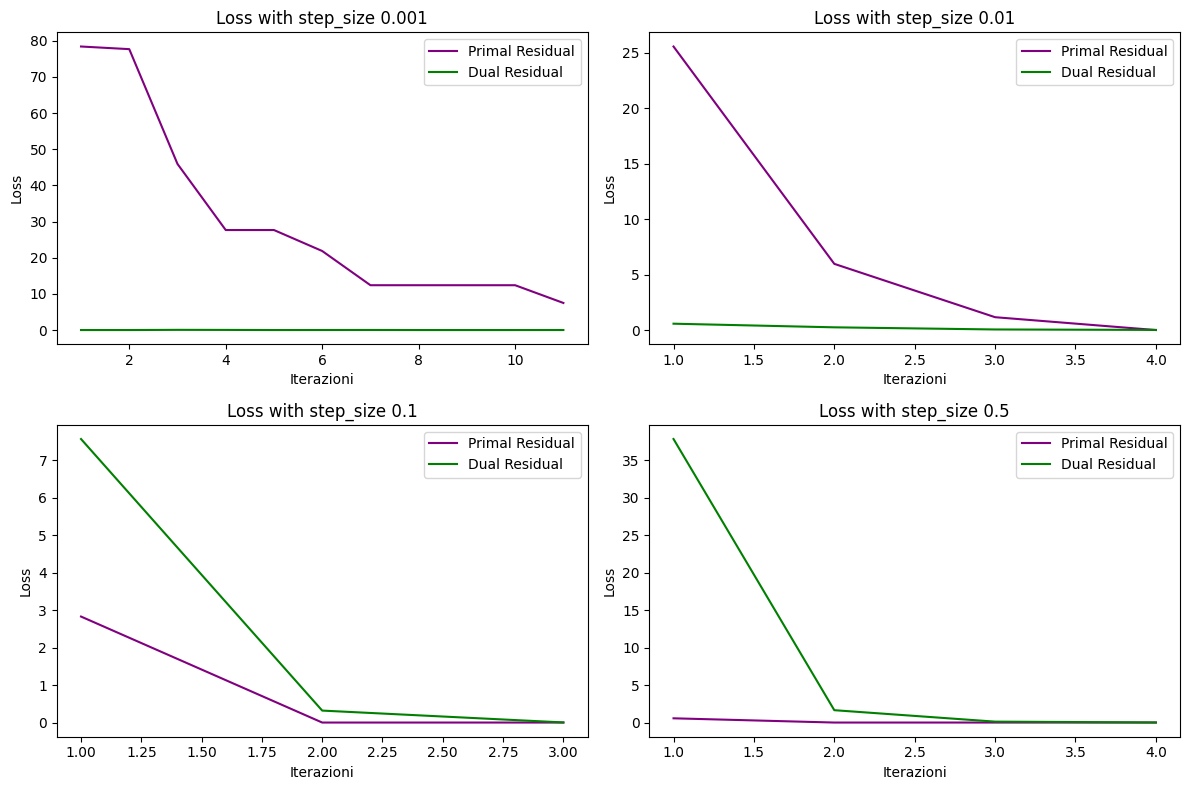

In [228]:
l1_penalty = 0.1
step_sizes = [0.001, 0.01, 0.1, 0.5]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, step_size in enumerate(step_sizes, 1):
    start_time = time.time()

    lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_admm.fit(X_train_real, y_train_real, algo="admm")
    admm_time = time.time() - start_time
    print(f"ADMM time with step_size {step_size}: {admm_time}")

    iterations_admm = lasso_admm.iterations
    print(f"ADMM iterations with step_size {step_size}: {iterations_admm}")

    y_pred_admm = lasso_admm.predict(X_test_real)

    r2 = 1 - np.mean((y_test_real - y_pred_admm) ** 2) / np.var(y_test_real)
    print(f"R^2 with step_size {step_size}: {r2}")

    while i > axs.size:
        axs = np.append(axs, plt.subplots(2, 2, figsize=(12, 8))[1], axis=0)

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_admm_val(axs[row, col], lasso_admm.J, f'Loss with step_size {step_size}')

plt.tight_layout()

plt.show()

Validation of l1_penalty parameter

ADMM time with l1_penalty 0.01: 0.0005064010620117188
ADMM iterations with l1_penalty 0.01: 3
R^2 with l1_penalty 0.01: 0.6238108758804706
ADMM time with l1_penalty 0.1: 0.0010008811950683594
ADMM iterations with l1_penalty 0.1: 4
R^2 with l1_penalty 0.1: 0.6237944166975957
ADMM time with l1_penalty 1: 0.0009720325469970703
ADMM iterations with l1_penalty 1: 11
R^2 with l1_penalty 1: 0.6236661607105725
ADMM time with l1_penalty 10: 0.01199960708618164
ADMM iterations with l1_penalty 10: 95
R^2 with l1_penalty 10: 0.6222661862743413


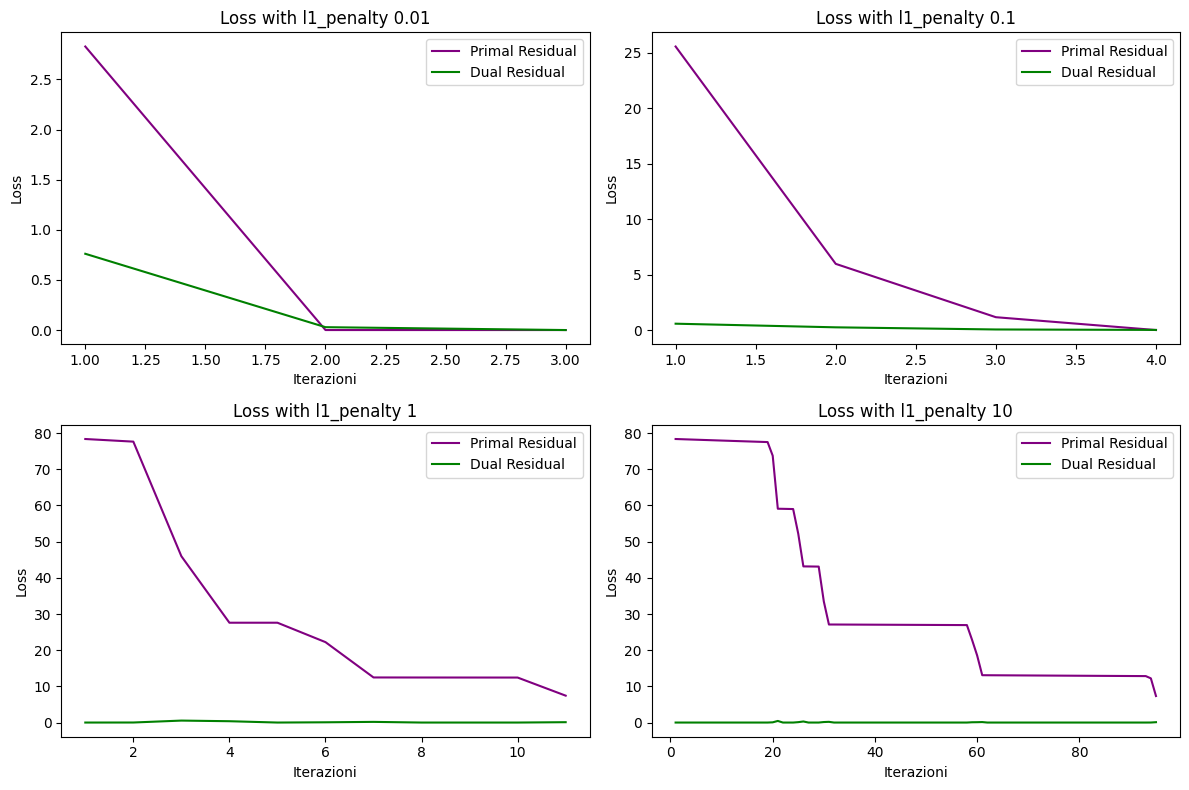

In [229]:
step_size = 0.01
l1_penalties = [0.01, 0.1, 1, 10]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, l1_penalty in enumerate(l1_penalties, 1):
    start_time = time.time()
    
    lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_admm.fit(X_train_real, y_train_real, algo="admm")
    admm_time = time.time() - start_time
    print(f"ADMM time with l1_penalty {l1_penalty}: {admm_time}")

    iterations_admm = lasso_admm.iterations
    print(f"ADMM iterations with l1_penalty {l1_penalty}: {iterations_admm}")
    
    y_pred_admm = lasso_admm.predict(X_test_real)

    r2 = r2_score(y_test_real, y_pred_admm)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

    while i > axs.size:
        axs = np.append(axs, plt.subplots(2, 2, figsize=(12, 8))[1], axis=0)

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_admm_val(axs[row, col], lasso_admm.J, f'Loss with l1_penalty {l1_penalty}')

plt.tight_layout()

plt.show()

### 4.2.3- Lasso Distributed ADMM

Validation of step_size parameter

Distributed ADMM time with step_size 0.001: 0.0019998550415039062
Distributed ADMM iterations with step_size 0.001: 5
R^2 with step_size 0.001: 0.622860909343039
Distributed ADMM time with step_size 0.01: 0.0
Distributed ADMM iterations with step_size 0.01: 3
R^2 with step_size 0.01: 0.622861290946441
Distributed ADMM time with step_size 0.1: 0.00099945068359375
Distributed ADMM iterations with step_size 0.1: 3
R^2 with step_size 0.1: 0.6228761363657842
Distributed ADMM time with step_size 0.5: 0.0010039806365966797
Distributed ADMM iterations with step_size 0.5: 5
R^2 with step_size 0.5: 0.6229870065658043


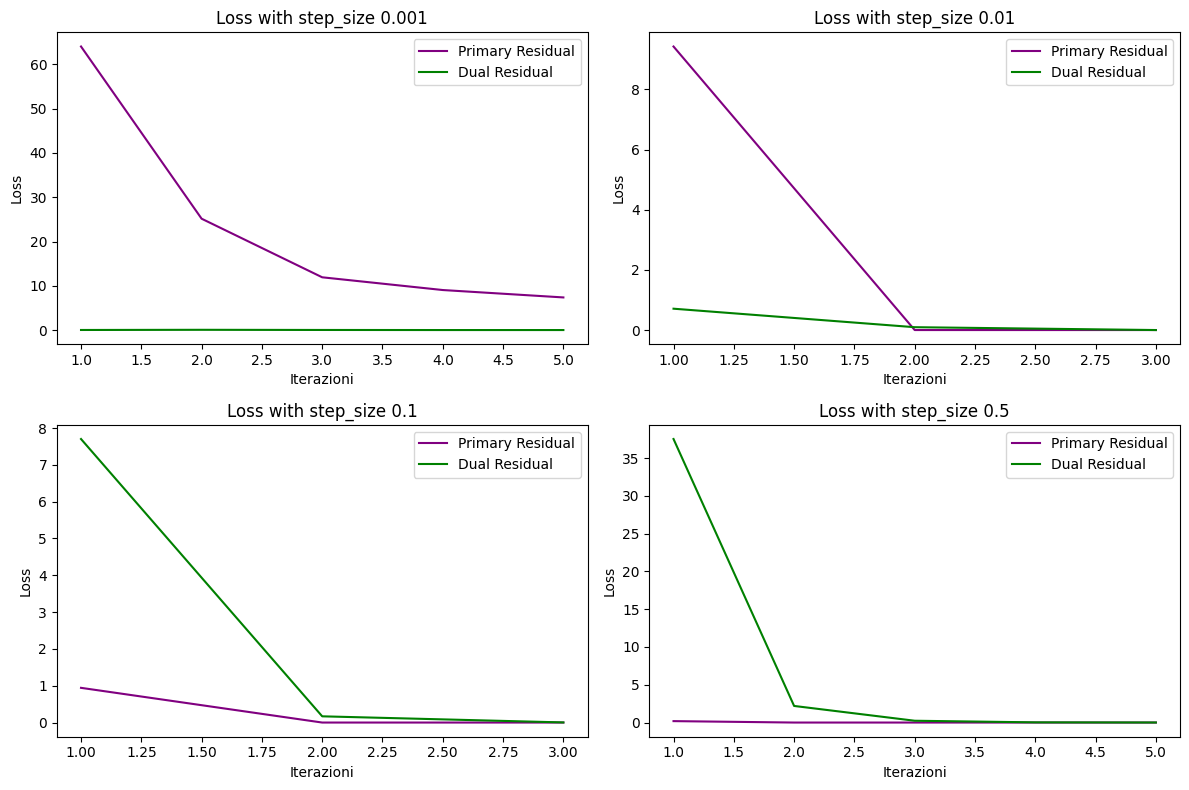

In [230]:
step_sizes = [0.001, 0.01, 0.1, 0.5]
l1_penalty = 0.1
agents = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, step_size in enumerate(step_sizes, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train_real, y_train_real, algo="distributed_admm", agents=agents)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with step_size {step_size}: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with step_size {step_size}: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_real)

    r2 = r2_score(y_test_real, y_pred_distributed_admm)
    print(f"R^2 with step_size {step_size}: {r2}")
    
    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with step_size {step_size}')

plt.tight_layout()

plt.show()

Validation of l1_penalty parameter

Distributed ADMM time with l1_penalty 0.01: 0.0010085105895996094
Distributed ADMM iterations with l1_penalty 0.01: 3
R^2 with l1_penalty 0.01: 0.6228846627687876
Distributed ADMM time with l1_penalty 0.1: 0.0009982585906982422
Distributed ADMM iterations with l1_penalty 0.1: 3
R^2 with l1_penalty 0.1: 0.6228761363657842
Distributed ADMM time with l1_penalty 1: 0.001004934310913086
Distributed ADMM iterations with l1_penalty 1: 3
R^2 with l1_penalty 1: 0.6227905830091359
Distributed ADMM time with l1_penalty 10: 0.0009999275207519531
Distributed ADMM iterations with l1_penalty 10: 5
R^2 with l1_penalty 10: 0.6220296299541633


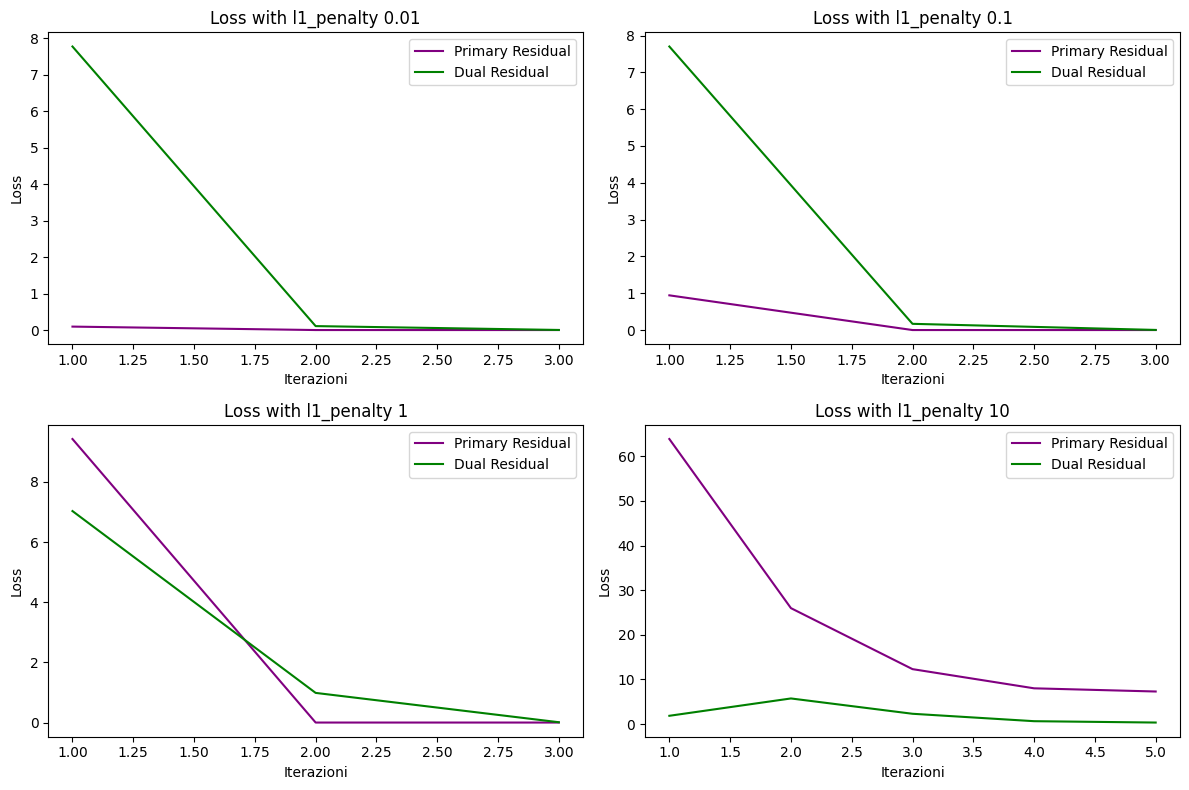

In [233]:
step_size = 0.1
l1_penalties = [0.01, 0.1, 1, 10]
agents = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, l1_penalty in enumerate(l1_penalties, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train_real, y_train_real, algo="distributed_admm", agents=agents)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with l1_penalty {l1_penalty}: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with l1_penalty {l1_penalty}: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_real)

    r2 = r2_score(y_test_real, y_pred_distributed_admm)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with l1_penalty {l1_penalty}')

plt.tight_layout()

plt.show()

Validation of num_agents parameters

Distributed ADMM time with 3 agents: 0.0019996166229248047
Distributed ADMM iterations with 3 agents: 3
R^2 with 3 agents: 0.6228761363657842
Distributed ADMM time with 5 agents: 0.001994609832763672
Distributed ADMM iterations with 5 agents: 4
R^2 with 5 agents: 0.6202937110885911
Distributed ADMM time with 10 agents: 0.012003660202026367
Distributed ADMM iterations with 10 agents: 22
R^2 with 10 agents: 0.621226360265406
Distributed ADMM time with 20 agents: 0.02600240707397461
Distributed ADMM iterations with 20 agents: 32
R^2 with 20 agents: 0.6210254330323816


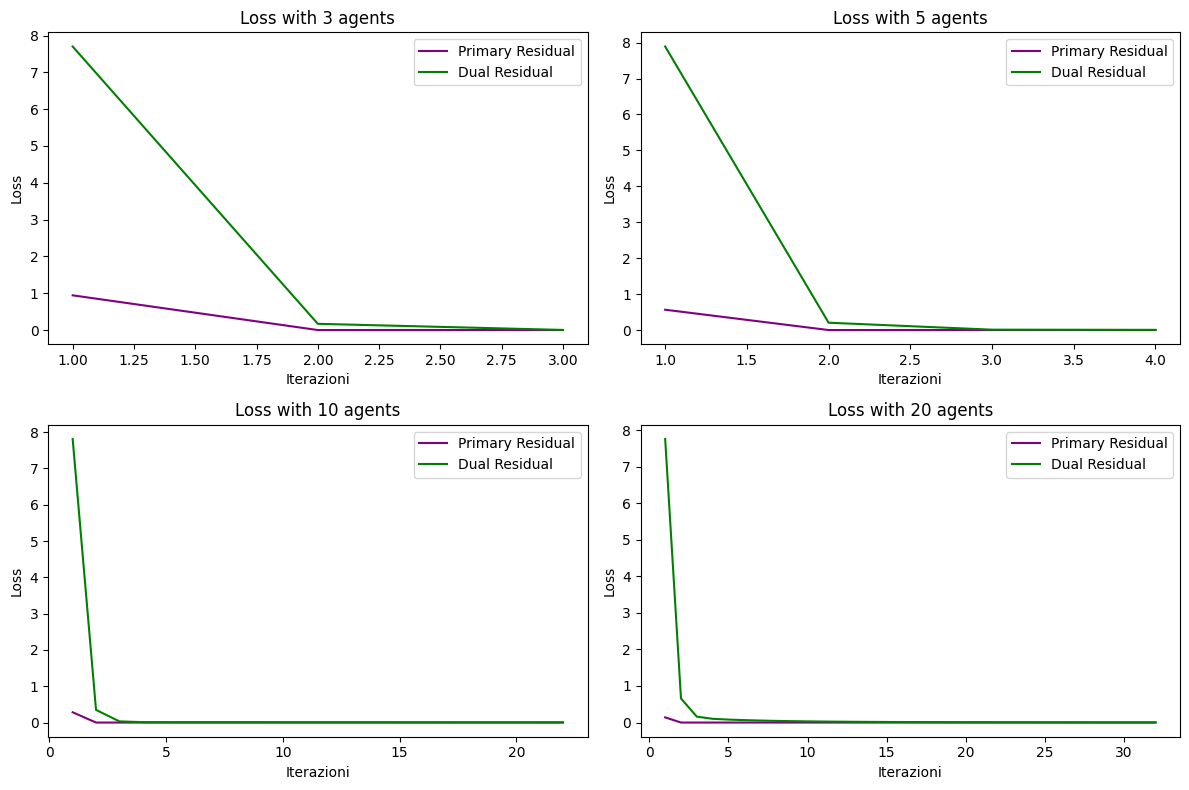

In [234]:
step_size = 0.1
l1_penalty = 0.1
agents = [3, 5, 10, 20]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, agent in enumerate(agents, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train_real, y_train_real, algo="distributed_admm", agents=agent)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with {agent} agents: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with {agent} agents: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_real)

    r2 = r2_score(y_test_real, y_pred_distributed_admm)
    print(f"R^2 with {agent} agents: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with {agent} agents')

plt.tight_layout()

plt.show()

### 4.2.2 Comparison of Lasso versions

Gradient Descent

GD time: 0.04053044319152832
GD iterations: 732
R^2: 0.6222018084294475
MSE: 98.06282708813579
MAE: 8.133112761933171


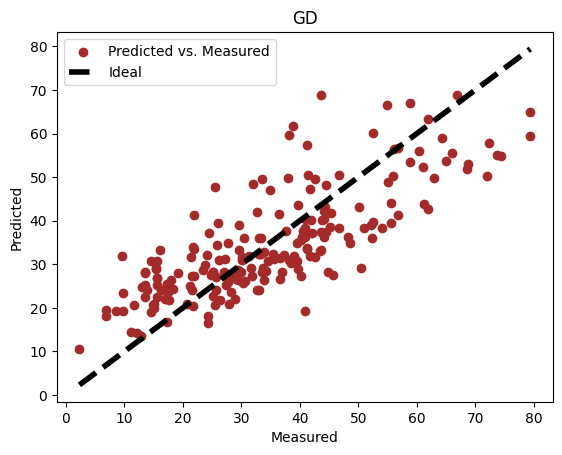

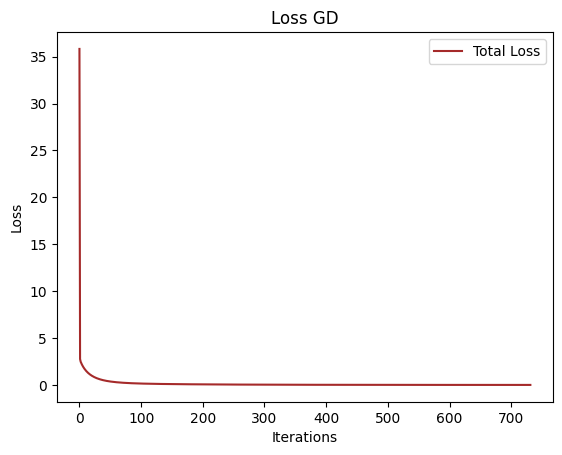

In [235]:
# parameters
step_size = 0.5
l1_penalty = 10

# GD
start_time = time.time()
lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_gd.fit(X_train_real, y_train_real, algo="gd")
gd_time = time.time() - start_time
print(f"GD time: {gd_time}")

iterations_gd = lasso_gd.iterations
print(f"GD iterations: {iterations_gd}")

y_pred_gd = lasso_gd.predict(X_test_real)

# metrics
r2_gd = r2_score(y_test_real, y_pred_gd)
print(f"R^2: {r2_gd}")

mse_gd = mean_squared_error(y_test_real, y_pred_gd)
print(f"MSE: {mse_gd}")
mae_gd = mean_absolute_error(y_test_real, y_pred_gd)
print(f"MAE: {mae_gd}")

# plots
prediction_plot(y_test_real, y_pred_gd, "GD")
loss_plot(lasso_gd.J, "Loss GD")

ADMM

ADMM time: 0.0020046234130859375
ADMM iterations: 3
R^2: 0.6238108758804706
MSE: 97.64517103063358
MAE: 8.110896744378458


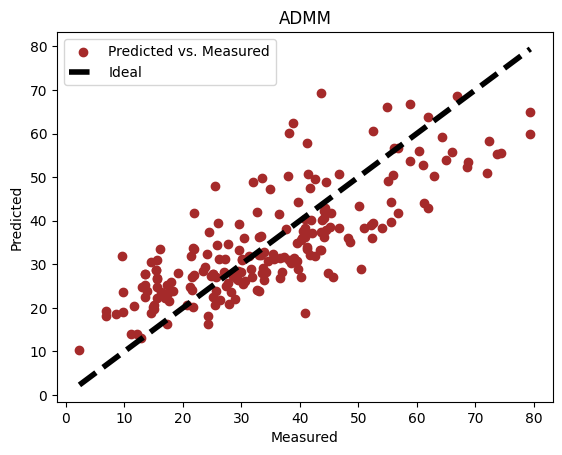

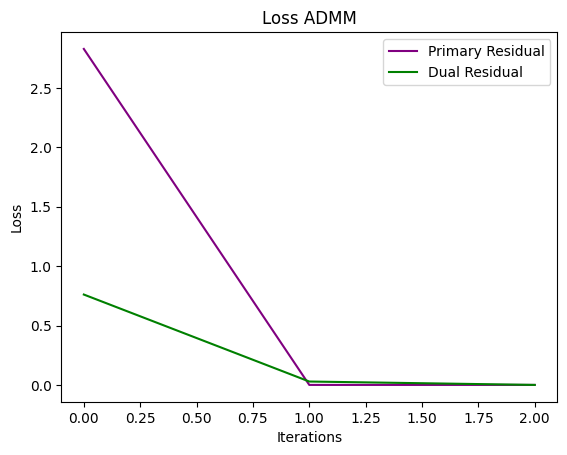

In [236]:
# parameters
step_size = 0.01
l1_penalty = 0.01

# ADMM
start_time = time.time()
lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_admm.fit(X_train_real, y_train_real, algo="admm")
admm_time = time.time() - start_time
print(f"ADMM time: {admm_time}")

iterations_admm = lasso_admm.iterations
print(f"ADMM iterations: {iterations_admm}")

y_pred_admm = lasso_admm.predict(X_test_real)

# metrics
r2_admm = r2_score(y_test_real, y_pred_admm)
print(f"R^2: {r2_admm}")

mse_admm = mean_squared_error(y_test_real, y_pred_admm)
print(f"MSE: {mse_admm}")
mae_admm = mean_absolute_error(y_test_real, y_pred_admm)
print(f"MAE: {mae_admm}")

# plots
prediction_plot(y_test_real, y_pred_admm, "ADMM")
loss_plot_admm(lasso_admm.J, "Loss ADMM")

Distributed ADMM

Distributed ADMM time: 0.0029931068420410156
Distributed ADMM iterations: 3
R^2: 0.6228761363657842
MSE: 97.88779580080542
MAE: 8.124023581383627


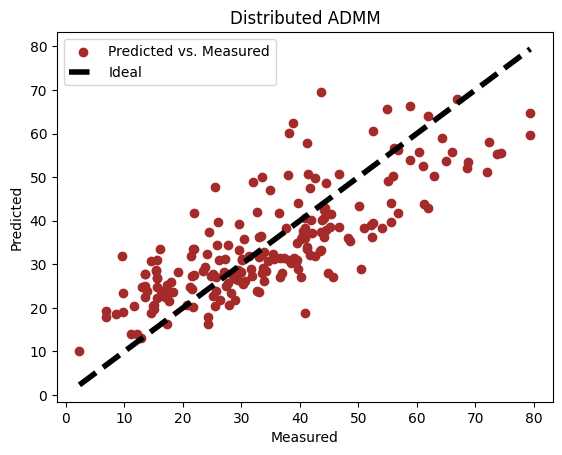

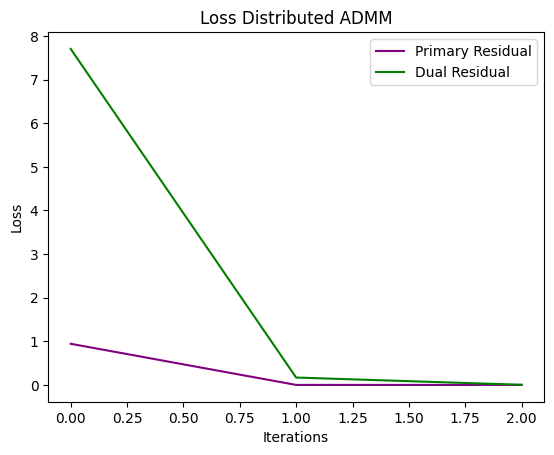

In [237]:
# parameters
step_size = 0.1
l1_penalty = 0.1
agents = 3

# Distributed ADMM
start_time = time.time()
lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_distributed_admm.fit(X_train_real, y_train_real, algo="distributed_admm", agents=agents)
distributed_admm_time = time.time() - start_time
print(f"Distributed ADMM time: {distributed_admm_time}")

iterations_distributed_admm = lasso_distributed_admm.iterations
print(f"Distributed ADMM iterations: {iterations_distributed_admm}")

y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_real)

# metrics
r2_distributed_admm = r2_score(y_test_real, y_pred_distributed_admm)
print(f"R^2: {r2_distributed_admm}")

mse_distributed_admm = mean_squared_error(y_test_real, y_pred_distributed_admm)
print(f"MSE: {mse_distributed_admm}")
mae_distributed_admm = mean_absolute_error(y_test_real, y_pred_distributed_admm)
print(f"MAE: {mae_distributed_admm}")

# plots
prediction_plot(y_test_real, y_pred_distributed_admm, "Distributed ADMM")
loss_plot_admm(lasso_distributed_admm.J, "Loss Distributed ADMM")